## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geocomp' #dataset-compression
TRANSFORM = 'fft-male' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_fft_1e5geocomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geocomp\\fft\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [ ]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


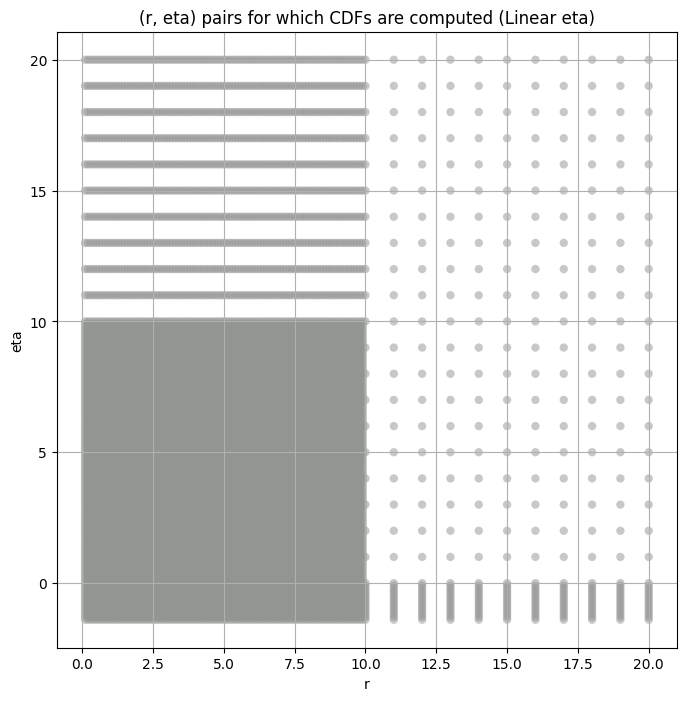

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 29


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     4.006317e+14  3.593028e+14  4.462146e+14    8.316574    5.757519   
5     9.461269e+14  8.322204e+14  1.067498e+15   21.399463   18.452861   
8     1.934537e+14  1.669650e+14  2.235244e+14   30.002404   21.744311   
11    1.438426e+13  1.162389e+13  1.914527e+13  100.202853   14.093921   
14    4.126319e+14  3.763275e+14  4.524124e+14   10.744119    7.456208   
17    3.881230e+14  3.657422e+14  4.122021e+14    3.374916    2.279853   
20    7.342718e+13  6.716078e+13  8.168062e+13   11.901693    5.121552   
23    1.111687e+13  1.043827e+13  1.190148e+13    4.427513    2.454238   
26    3.114394e+12  2.886462e+12  3.378224e+12    7.238748    4.201065   
29    6.576215e+10  6.101267e+10  7.119539e+10    6.770875    4.171933   

      kurt_upper  total_samples  
band                             
2      10.650913         2880.0  
5      24.572022         8640.0  
8      39.769151        24480.0  
11    274.104715        67680.0  
14     16.715038       100000.0  
17      6.281314       100000.0  
20     40.059997       100000.0  
23     12.285351       100000.0  
26     17.518762       100000.0  
29     17.270431       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     4.006317e+14   4.006317e+14    3.055908e+14    2.678364e+14   
5     9.461269e+14   9.461269e+14    7.741529e+14    6.687720e+14   
8     1.934537e+14   1.934537e+14    1.706179e+14    1.568946e+14   
11    1.438426e+13   1.438426e+13    1.189889e+13    1.114970e+13   
14    4.126319e+14   4.126319e+14    3.957000e+14    3.858047e+14   
17    3.881230e+14   3.881230e+14    3.796416e+14    3.743841e+14   
20    7.342718e+13   7.342718e+13    6.993956e+13    6.828030e+13   
23    1.111687e+13   1.111687e+13    1.082212e+13    1.065667e+13   
26    3.114394e+12   3.114394e+12    3.005852e+12    2.945052e+12   
29    6.576215e+10   6.576215e+10    6.372956e+10    6.256220e+10   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       2.451870e+14     2.279837e+14     2.015892e+14     1.818231e+14   
5       5.884705e+14     5.271014e+14     4.391410e+14     3.760049e+14   
8       1.462764e+14     1.379441e+14     1.254449e+14     1.154033e+14   
11      1.080148e+13     1.054766e+13     1.016022e+13     9.871023e+12   
14      3.778040e+14     3.709209e+14     3.592130e+14     3.490550e+14   
17      3.700048e+14     3.661255e+14     3.593199e+14     3.533159e+14   
20      6.697666e+13     6.587287e+13     6.401378e+13     6.245458e+13   
23      1.052075e+13     1.040140e+13     1.019491e+13     1.001646e+13   
26      2.895879e+12     2.853401e+12     2.780953e+12     2.719339e+12   
29      6.159222e+10     6.073959e+10     5.925895e+10     5.797852e+10   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.657560e+14     1.518568e+14     1.395807e+14     1.100437e+14  
5        3.292488e+14     2.936576e+14     2.644512e+14     2.024620e+14  
8        1.068531e+14     9.952216e+13     9.326665e+13     7.885553e+13  
11       9.633622e+12     9.425172e+12     9.237470e+12     8.783965e+12  
14       3.400342e+14     3.318874e+14     3.243921e+14     3.049557e+14  
17       3.479066e+14     3.429583e+14     3.383716e+14     3.261546e+14  
20       6.109807e+13     5.988178e+13     5.877675e+13     5.594621e+13  
23       9.856975e+12     9.712069e+12     9.578420e+12     9.226027e+12  
26       2.665129e+12     2.616352e+12     2.571733e+12     2.455848e+12  
29       5.683561e+10     5.579489e+10     5.483490e+10     5.231146e+10

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.010391424385800596 400631716371793.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.006903771906855594 305590768889036.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.013028833041163645 267836364475261.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.019345124806667835 245186975104793.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.024265595139780882 227983681452511.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.032709806063248914 201589157529164.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.04011472368423841 181823071767440.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.04888788465209537 165756003212077.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.057716643900977194 151856810890340.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.06646975781727793 139580675028641.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.0932460832112244 110043727835900.94
Number of samples: 5760, Without approximation : 2880.0


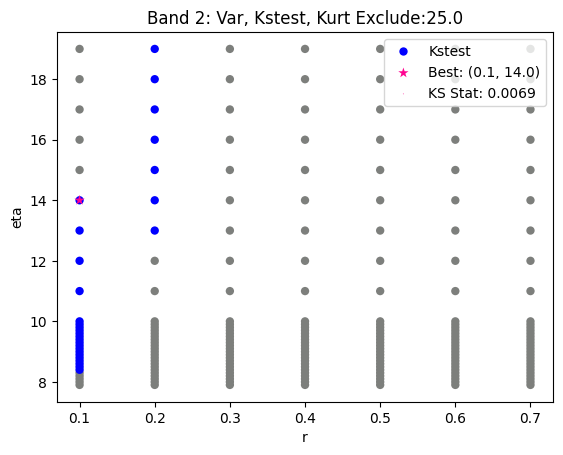

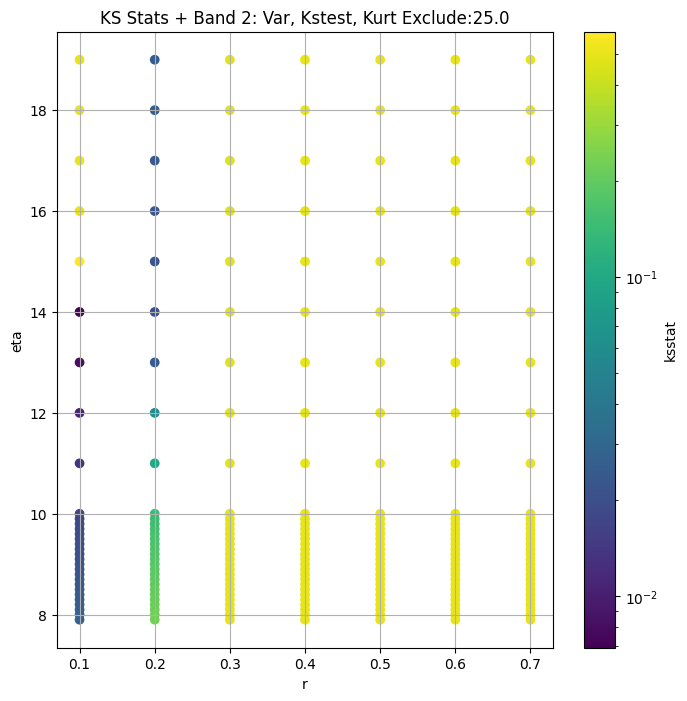

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.029219327081372315 946126933927359.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.025590760315606642 774152878424655.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.022384718365136003 668771996033659.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.01976916527759265 588470451205728.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.017429930652516468 527101400245893.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.014008709408128761 439141000768260.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.017379938467052547 376004886266121.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.020276846681071103 329248790119841.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0227452706663618 293657646936929.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.02506352874118375 264451197019507.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03216433146247794 202461974067878.22
Number of samples: 17280, Without approximation : 8640.0


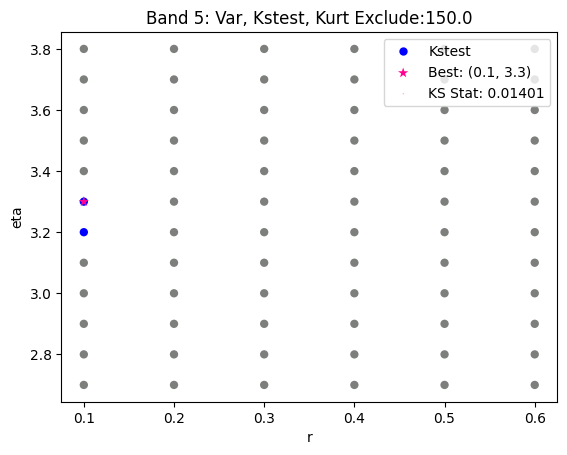

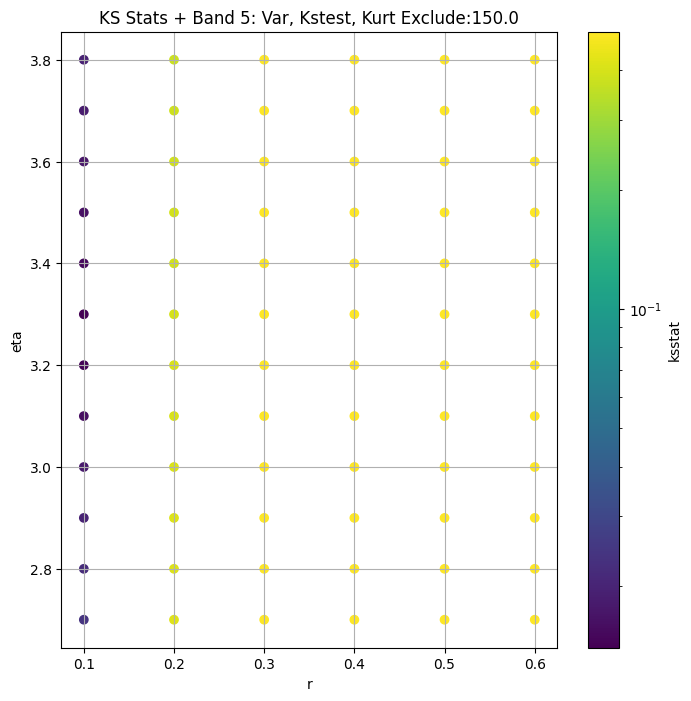

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.020964083747019774 193453683221031.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.020964083747019774 170617938791616.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.020964083747019774 156894550138648.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.020843526777720778 146276356753516.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01998708905287322 137944122365370.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.017421747353575046 125444854736696.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.014956468157404035 115403261689478.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013217564016332783 106853061628552.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.011223586372013206 99522160210911.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.01048540255362897 93266653146143.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.013212283308982014 78855530520459.72
Number of samples: 48960, Without approximation : 24480.0


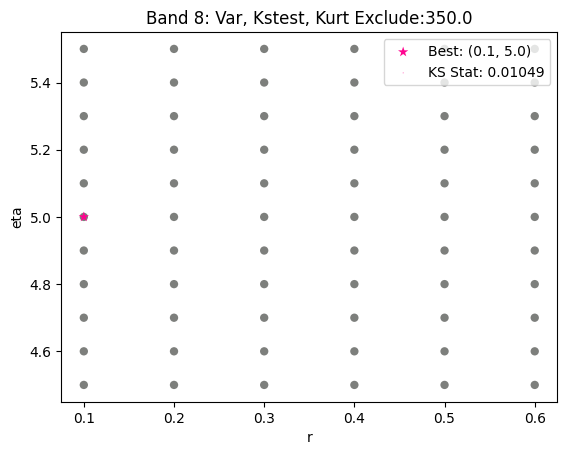

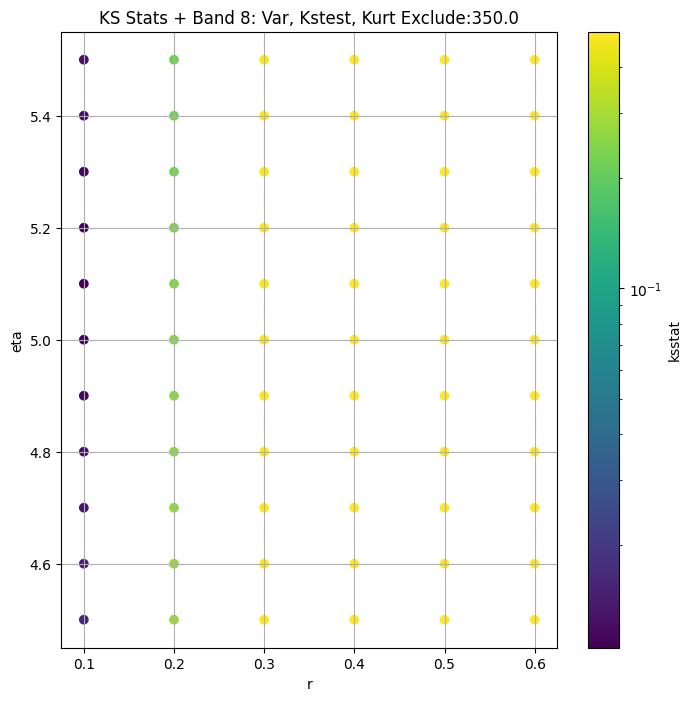

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.0072912764809464625 14384255303088.066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.0072912764809464625 11898886696692.54


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0072912764809464625 11149699965011.574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.0072912764809464625 10801476842111.113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.006583212420176676 10547656684226.41


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0052367509632374465 10160217783533.426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.0040870171099568475 9871022601033.672


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.0038803773181831777 9633622396459.65


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.004247140949450504 9425171561299.844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.00461588676333505 9237470426356.082


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.005732048007146242 8783965399996.048
Number of samples: 100000, Without approximation : 67680.0


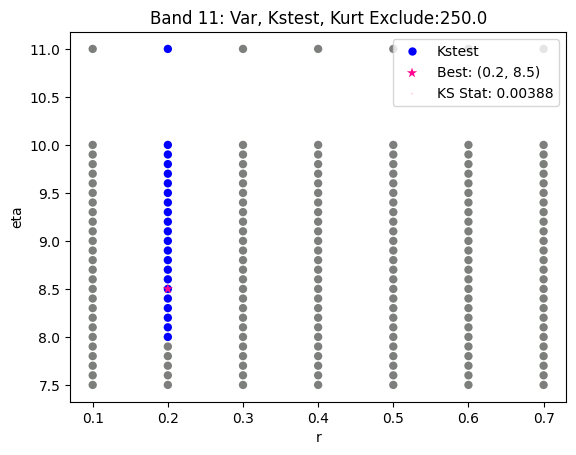

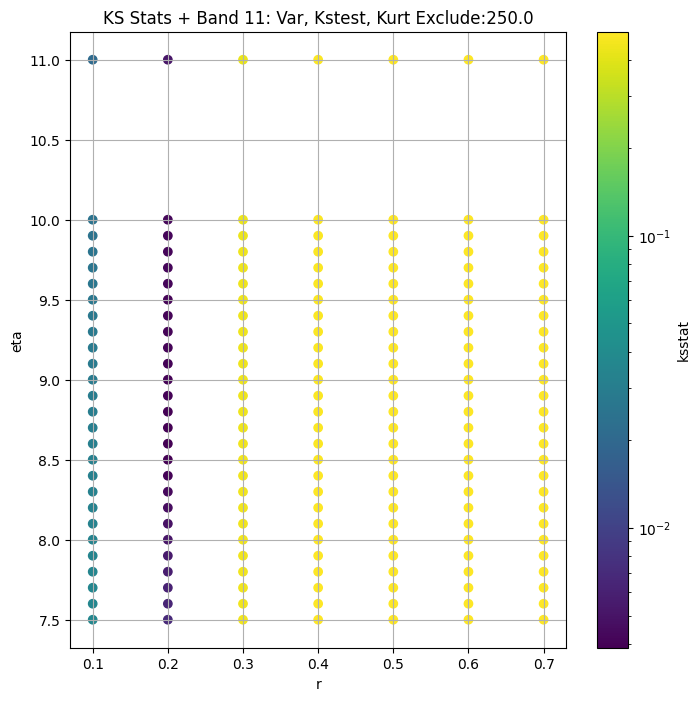

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.01868087733407224 412631882902065.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.0192187648978097 395700003029904.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.020782074245536478 385804668203842.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.020174267250334443 377804022120763.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.021314228289800008 370920891621738.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.02158695429487989 359213028383064.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.02221031097018278 349054963910771.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02334579464116808 340034213955406.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.023489258385342257 331887389421589.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.024016345006786954 324392053983547.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.025874521321261446 304955655679668.7
Number of samples: 100000, Without approximation : 100000.0


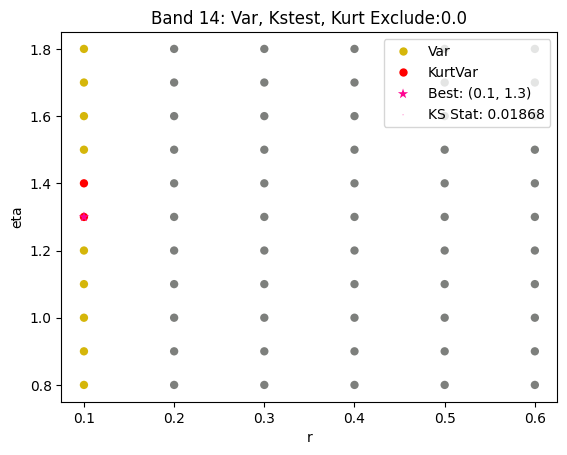

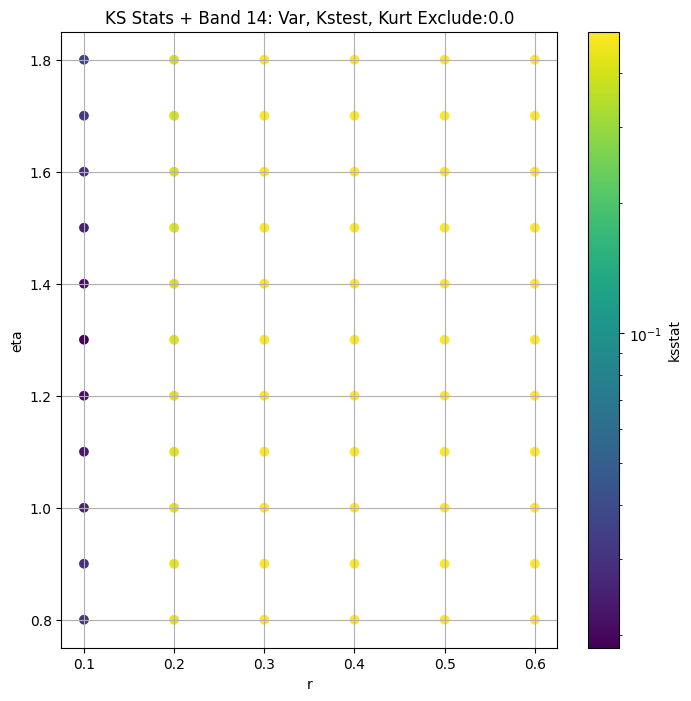

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.002003152511192069 388122981379094.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.0028617215527872997 379641598277569.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.0031766080207984992 374384071406958.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.0037289610326137757 370004804874437.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.00372427027934593 366125476700060.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.004582496087082277 359319862517816.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.005385684825747139 353315907985332.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.00630202116529599 347906554974817.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.007283887644041989 342958295650062.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.008272751033096853 338371613347697.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.011520603456423237 326154623990460.56
Number of samples: 100000, Without approximation : 100000.0


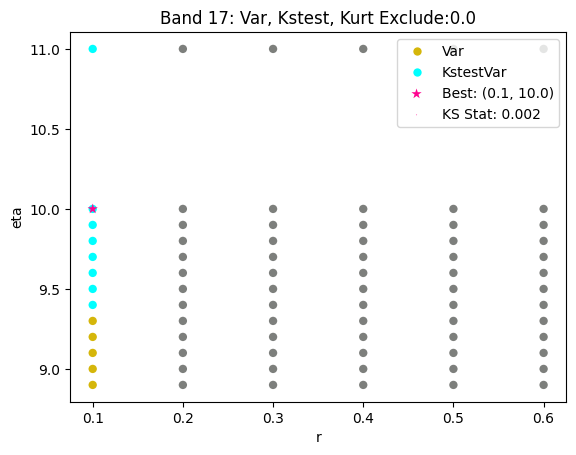

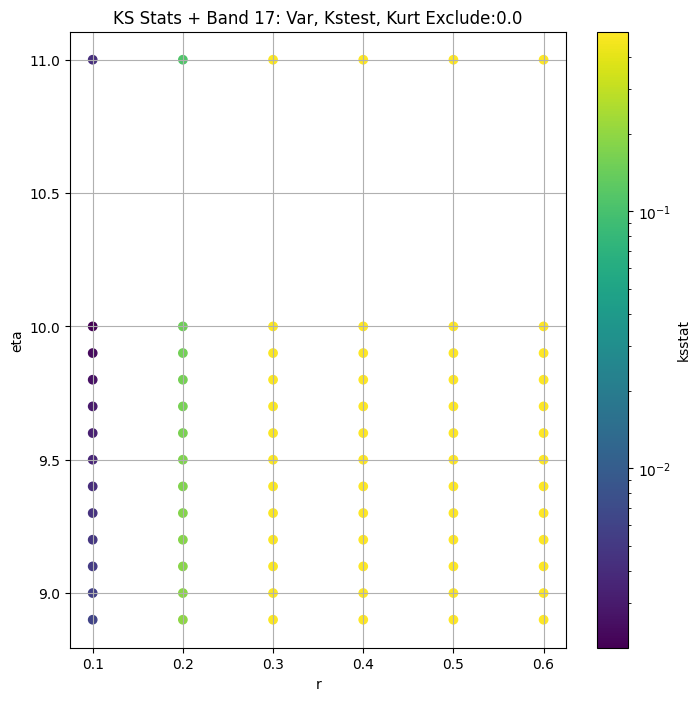

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.005586671367232787 73427182295489.95


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.00404529424735256 69939558688939.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.003353594161594975 68280300841399.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.002656248849746634 66976664808755.21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0023226763344751065 65872868398802.54


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.002990719075188872 64013779007361.49


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.003733811551891505 62454576015137.32


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.004454323472372051 61098067684055.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.005245267900429014 59881778924187.04


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006006148965232414 58776749199583.81


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.00810484911268736 55946207311671.016
Number of samples: 100000, Without approximation : 100000.0


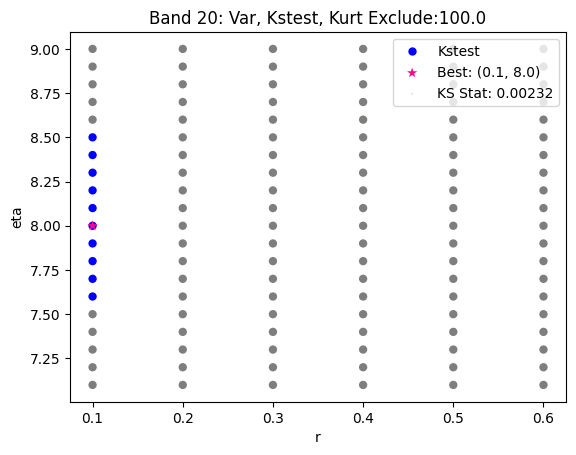

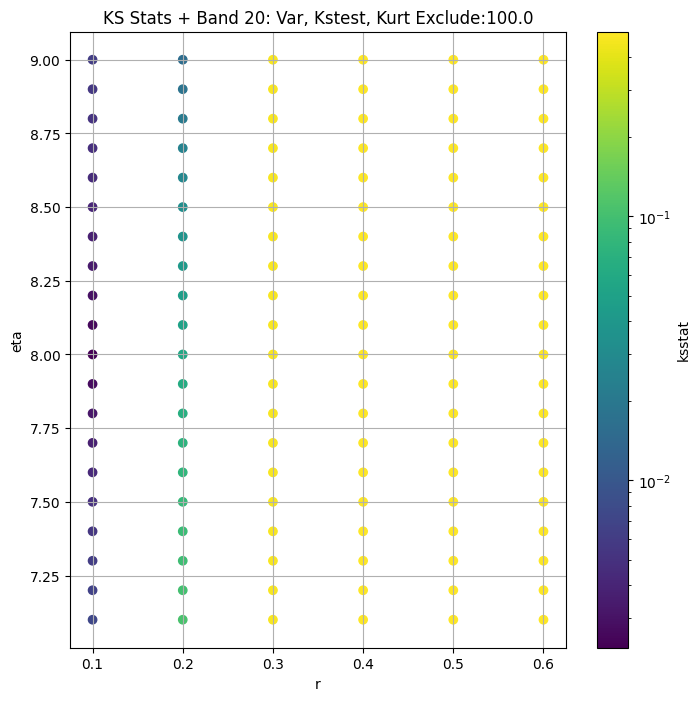

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0016811203691249332 11116873638858.572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0008036548109976449 10822123149919.742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.0012140727703986547 10656665189063.217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0015798235531327316 10520746265394.385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0020550125684714107 10401397065165.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0028774019137697213 10194909205878.297


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0037639365559444457 10016455116151.584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004592223884820439 9856974730253.969


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005380431275804329 9712069320144.986


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006129916679880325 9578420106758.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008258292264761859 9226027200734.445
Number of samples: 100000, Without approximation : 100000.0


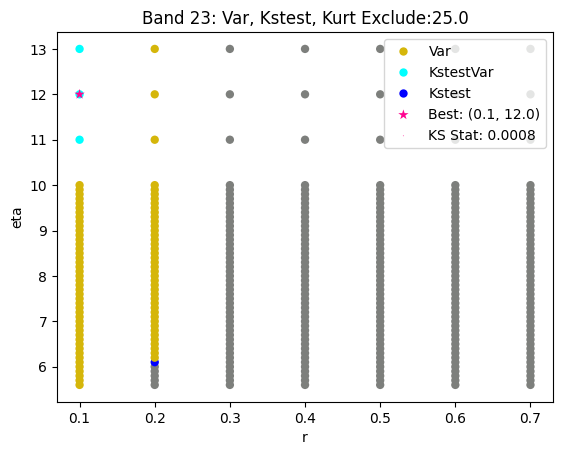

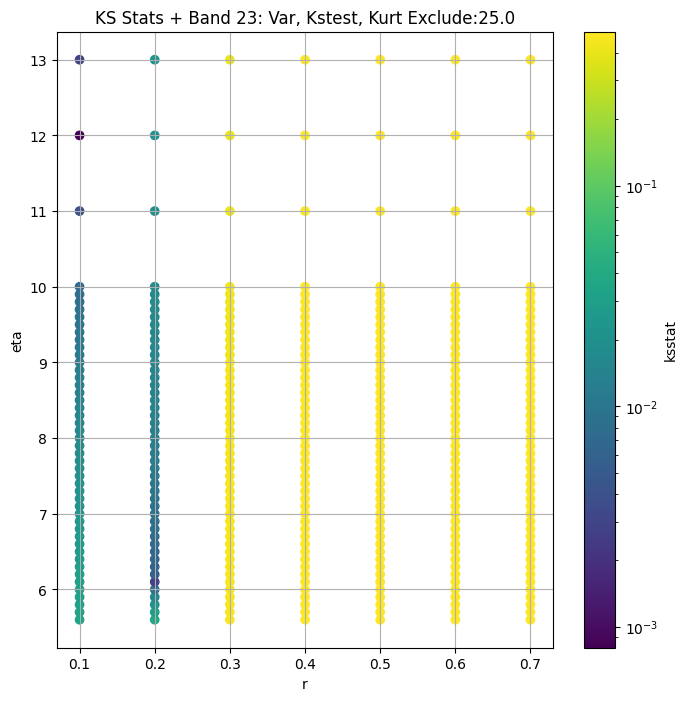

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0006164542568853904 3114393648514.945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0009961512808240869 3005852429549.024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0017111113666659766 2945051671852.624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0023818458094846395 2895879483446.0874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.002966104800894473 2853401147623.2056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.00398983730540451 2780953110971.7163


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.004903691768845413 2719339245536.509


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005785644887255401 2665129362788.0337


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006459316340407639 2616351694903.07


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.006985151353603954 2571732516815.4155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.009186960616739119 2455848147712.48
Number of samples: 100000, Without approximation : 100000.0


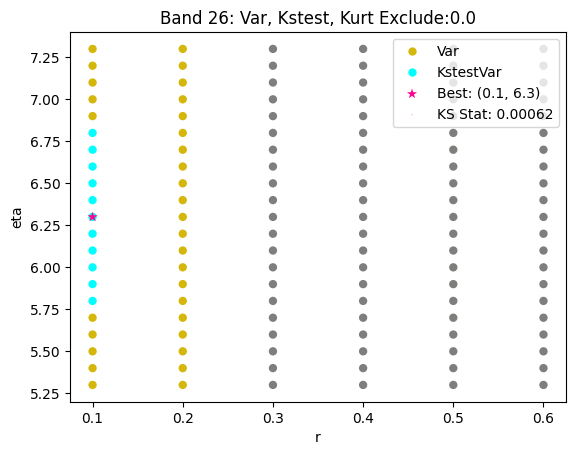

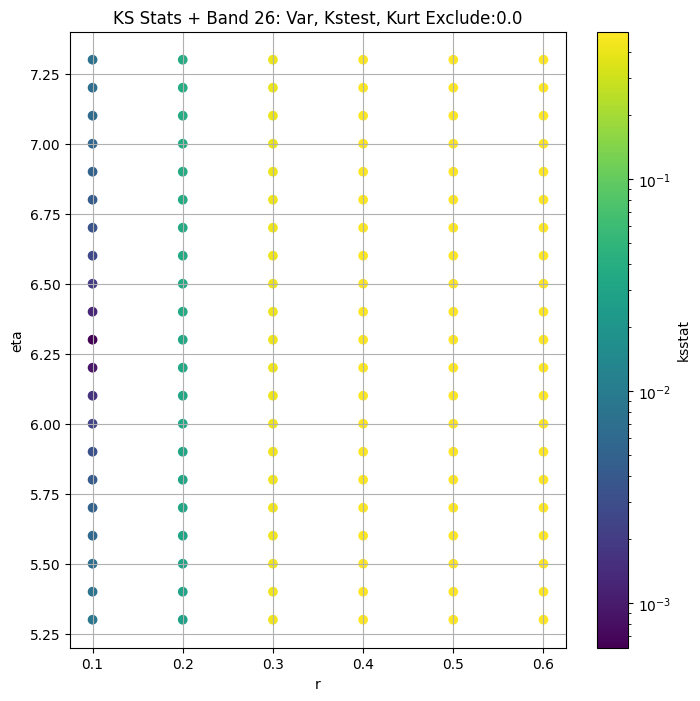

####
Band  29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 0 0.0021862026414314617 65762145352.27044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 25 0.0030160617287310204 63729561196.566925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 50 0.003714708731552538 62562204998.12691


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 75 0.004278389157658366 61592223080.54566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 100 0.004768978834645693 60739585150.4249


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 150 0.005849161908827227 59258951901.64015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 200 0.006675191365402289 57978518786.03225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 250 0.007397063318730218 56835614095.34639


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 300 0.008232421023043002 55794887088.30164


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 350 0.008927142938554365 54834902400.217804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 500 0.010909709628512565 52311457192.89636
Number of samples: 100000, Without approximation : 100000.0


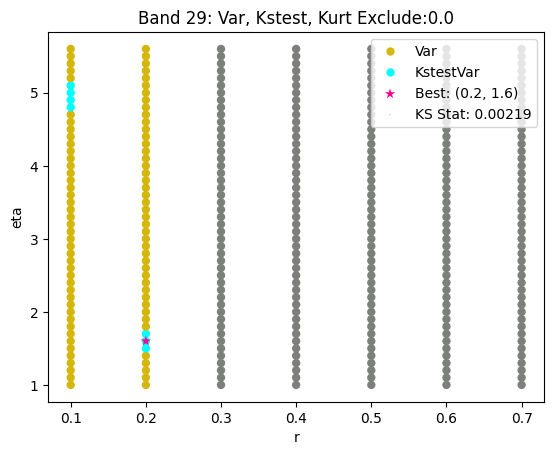

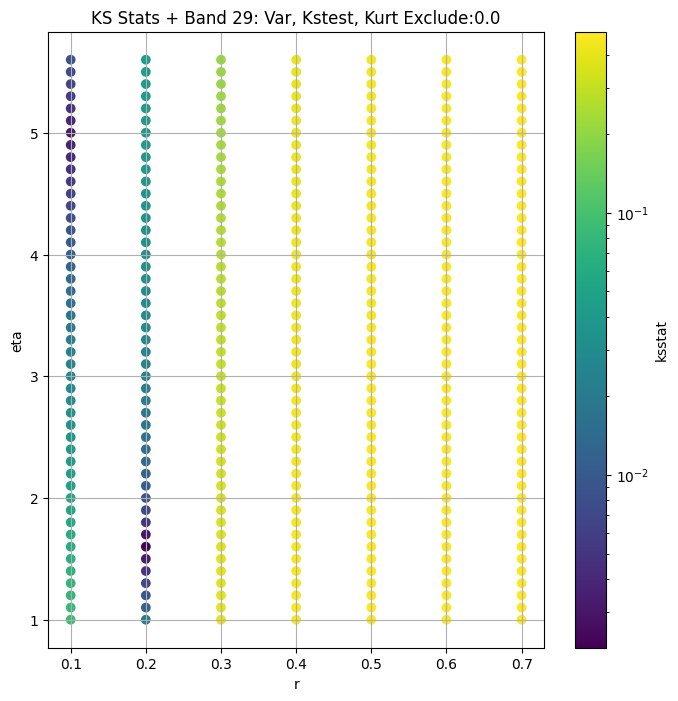

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     4.006317e+14  3.593028e+14  4.462146e+14    8.316574    5.757519   
5     9.461269e+14  8.322204e+14  1.067498e+15   21.399463   18.452861   
8     1.934537e+14  1.669650e+14  2.235244e+14   30.002404   21.744311   
11    1.438426e+13  1.162389e+13  1.914527e+13  100.202853   14.093921   
14    4.126319e+14  3.763275e+14  4.524124e+14   10.744119    7.456208   
17    3.881230e+14  3.657422e+14  4.122021e+14    3.374916    2.279853   
20    7.342718e+13  6.716078e+13  8.168062e+13   11.901693    5.121552   
23    1.111687e+13  1.043827e+13  1.190148e+13    4.427513    2.454238   
26    3.114394e+12  2.886462e+12  3.378224e+12    7.238748    4.201065   
29    6.576215e+10  6.101267e+10  7.119539e+10    6.770875    4.171933   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      10.650913         2880.0             0.006904        0.1         14.0   
5      24.572022         8640.0             0.014009        0.1          3.3   
8      39.769151        24480.0             0.010485        0.1          5.0   
11    274.104715        67680.0             0.003880        0.2          8.5   
14     16.715038       100000.0             0.018681        0.1          1.3   
17      6.281314       100000.0             0.002003        0.1         10.0   
20     40.059997       100000.0             0.002323        0.1          8.0   
23     12.285351       100000.0             0.000804        0.1         12.0   
26     17.518762       100000.0             0.000616        0.1          6.3   
29     17.270431       100000.0             0.002186        0.2          1.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.872353e-08                    25.0        3.055908e+14   
5      2.802386e-03                   150.0        4.391410e+14   
8      3.577609e-05                   350.0        9.326665e+13   
11     2.538496e+04                   250.0        9.633622e+12   
14     3.264440e-01                     0.0        4.126319e+14   
17     6.554589e-07                     0.0        3.881230e+14   
20     6.954832e-07                   100.0        6.587287e+13   
23     3.885897e-09                    25.0        1.082212e+13   
26     2.145206e-07                     0.0        3.114394e+12   
29     4.073014e+04                     0.0        6.576215e+10   

      kstest_stat_cutoff_0.05  
band                           
2                    0.025248  
5                    0.014591  
8                    0.008673  
11                   0.005218  
14                   0.004293  
17                   0.004293  
20                   0.004293  
23                   0.004293  
26                   0.004293  
29                   0.004293

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.028895773584321334, var: 213703496184143.9


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.024409892367168763, var: 227983681452511.12


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.019539073417473518, var: 245186975104793.7


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.01339982987858266, var: 267836364475261.9


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.006640832106870498, var: 305590768889036.6


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.024364200429859068, var: 400631716371793.0
Number of samples: 5760, Without approximation : 2880.0


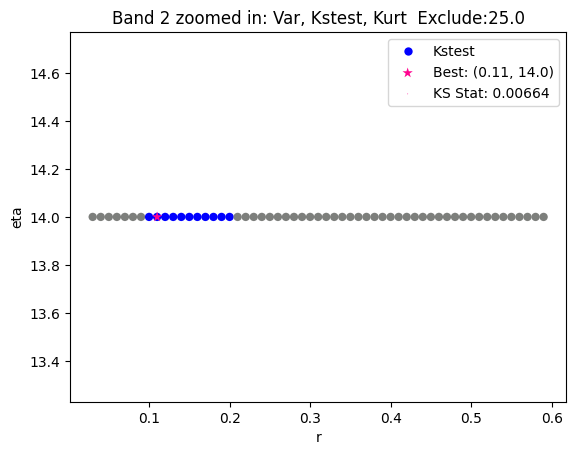

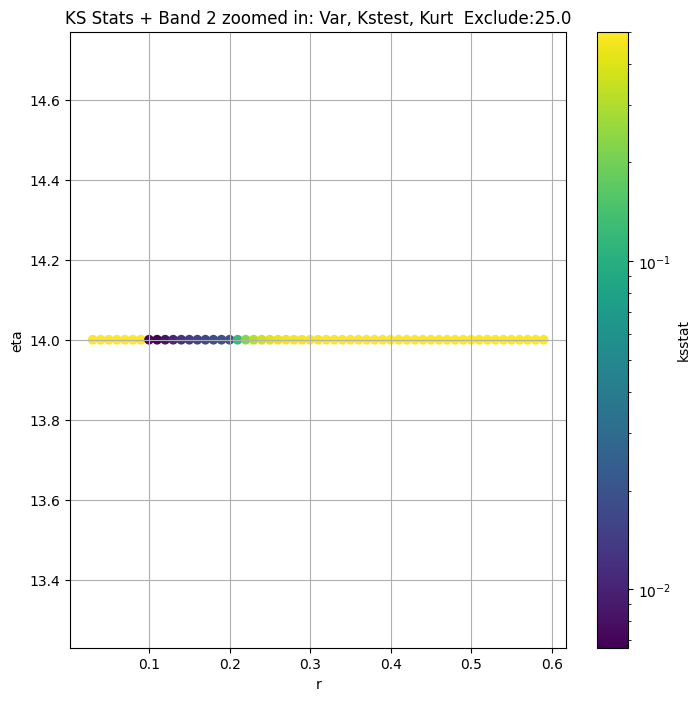

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 100 = 250, ksstat: 0.020233232723542605, var: 329248790119841.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 75 = 225, ksstat: 0.018805034849289953, var: 351306597978510.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 50 = 200, ksstat: 0.017324358625499116, var: 376004886266121.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 25 = 175, ksstat: 0.015645141720454128, var: 404647361848062.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + 0 = 150, ksstat: 0.014008709408128761, var: 439141000768260.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -25 = 125, ksstat: 0.015535678221790666, var: 479528110183246.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -50 = 100, ksstat: 0.01740057054398625, var: 527101400245893.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -75 = 75, ksstat: 0.0188297585814573, var: 588470451205728.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 150.0 + -100 = 50, ksstat: 0.021093210339937718, var: 668771996033659.9
Number of samples: 17280, Without approximation : 8640.0


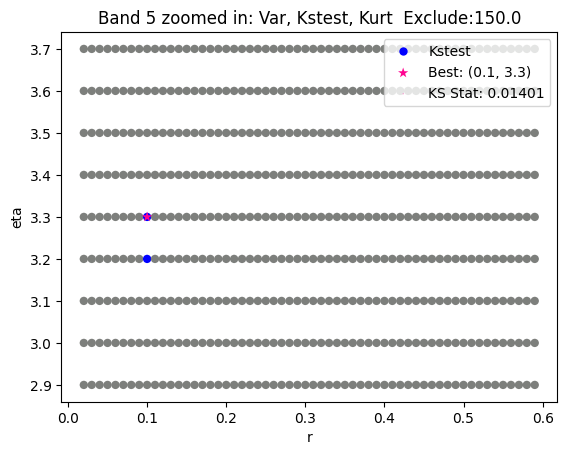

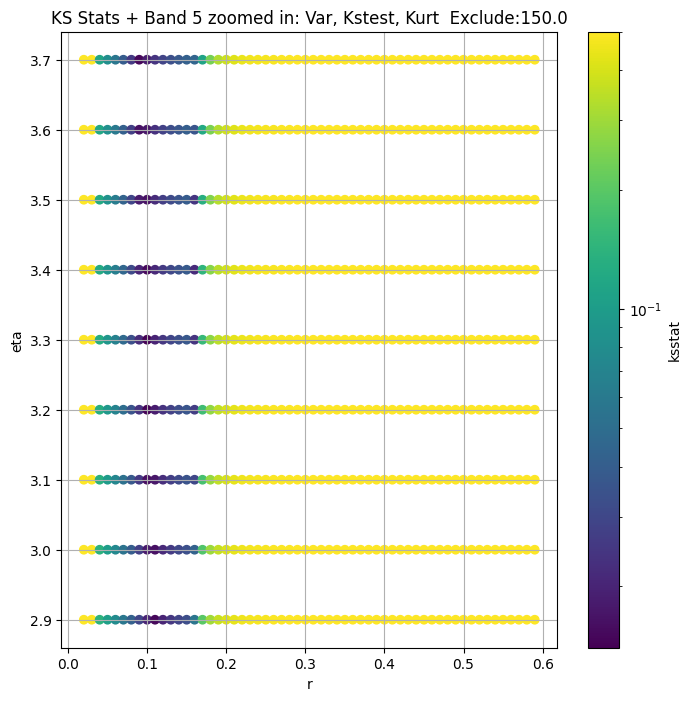

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 100 = 450, ksstat: 0.012296783644487875, var: 83082625009350.31


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 75 = 425, ksstat: 0.011817144951634237, var: 85411891437147.83


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 50 = 400, ksstat: 0.011380538977803, var: 87878467965190.97


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 25 = 375, ksstat: 0.010957502439232103, var: 90486388493809.42


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + 0 = 350, ksstat: 0.01048540255362897, var: 93266653146143.52


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -25 = 325, ksstat: 0.010485792171401179, var: 96285712619361.33


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -50 = 300, ksstat: 0.011089943638745131, var: 99522160210911.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -75 = 275, ksstat: 0.01196388369431585, var: 103043675113086.47


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 350.0 + -100 = 250, ksstat: 0.01281431515979048, var: 106853061628552.84
Number of samples: 48960, Without approximation : 24480.0


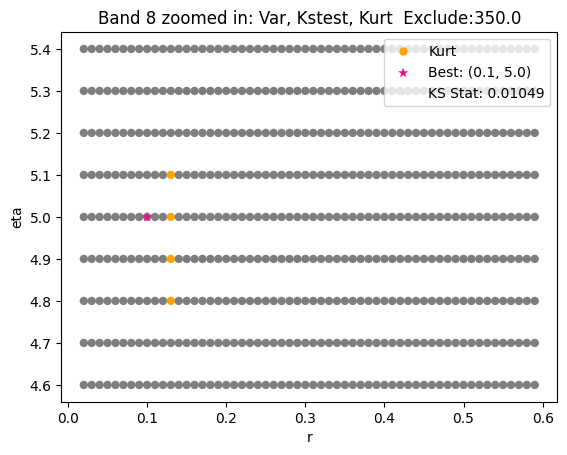

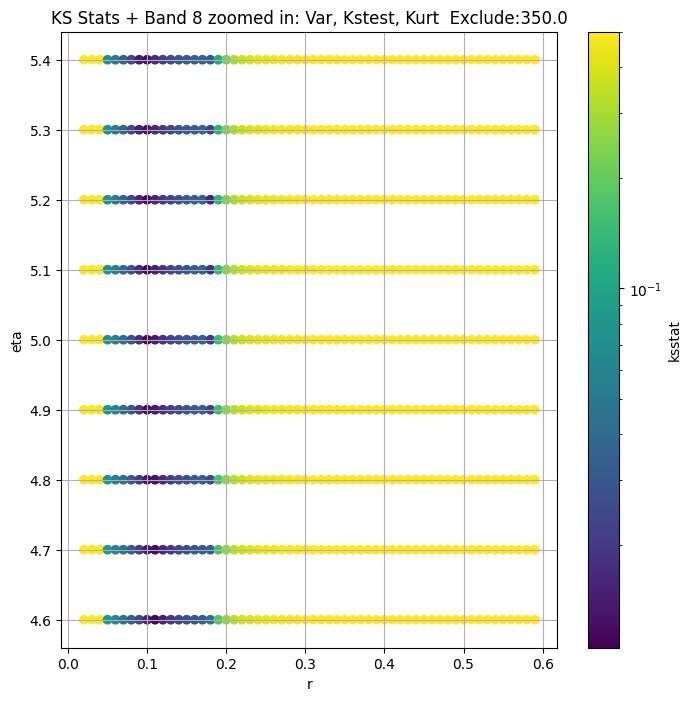

Band 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + 100 = 350, ksstat: 0.005144759847340419, var: 9237470426356.082


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + 75 = 325, ksstat: 0.004436534731085018, var: 9328529307526.326


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + 50 = 300, ksstat: 0.004254368136692793, var: 9425171561299.844


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + 25 = 275, ksstat: 0.0040524675053633, var: 9527335999226.246


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + 0 = 250, ksstat: 0.0038803773181831777, var: 9633622396459.65


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + -25 = 225, ksstat: 0.0037085682377655865, var: 9747498907243.188


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + -50 = 200, ksstat: 0.0038344026784115693, var: 9871022601033.672


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + -75 = 175, ksstat: 0.0038344026784115693, var: 10007005004657.998


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 250.0 + -100 = 150, ksstat: 0.0038344026784115693, var: 10160217783533.426
Number of samples: 100000, Without approximation : 67680.0


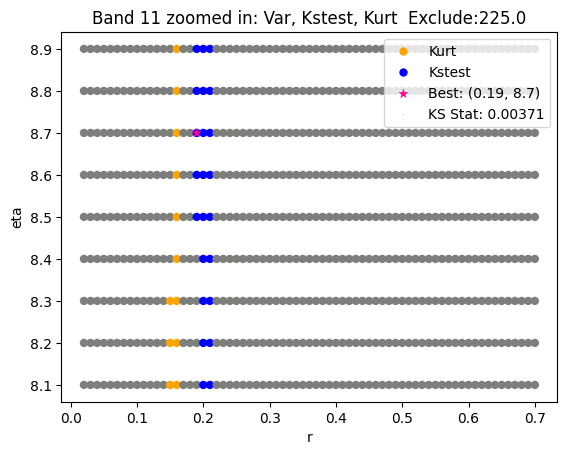

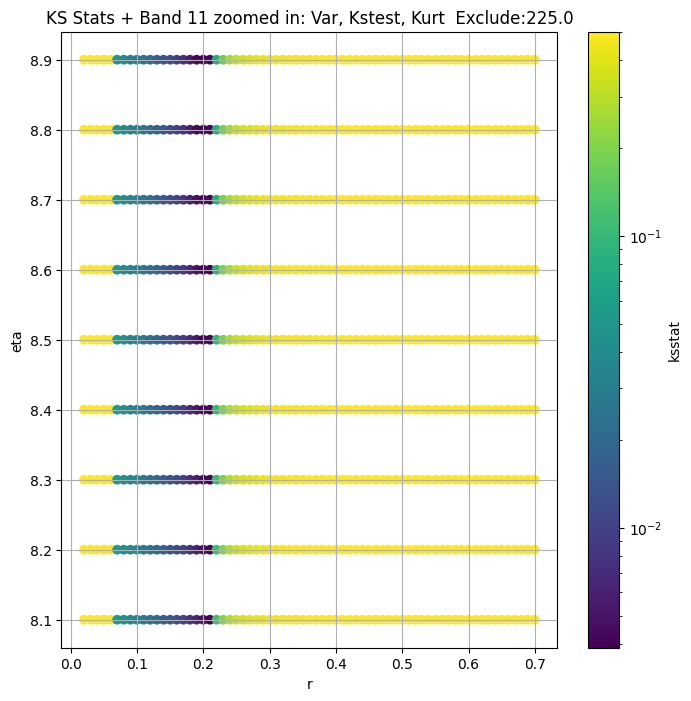

Band 14


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.019932180782255227, var: 370920891621738.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.019938119782501693, var: 377804022120763.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.019556945646533555, var: 385804668203842.4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.019180966206531952, var: 395700003029904.5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.01868087733407224, var: 412631882902065.4
Number of samples: 100000, Without approximation : 100000.0


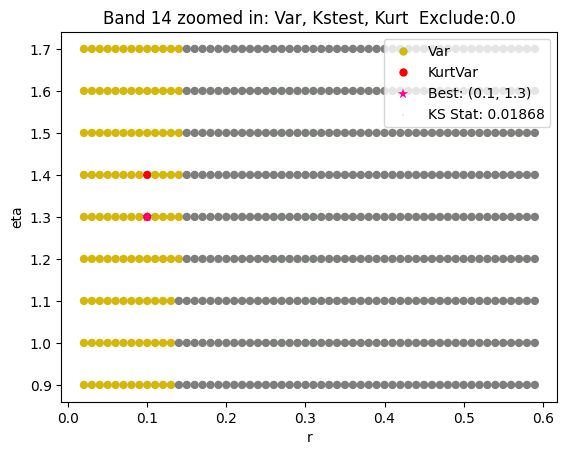

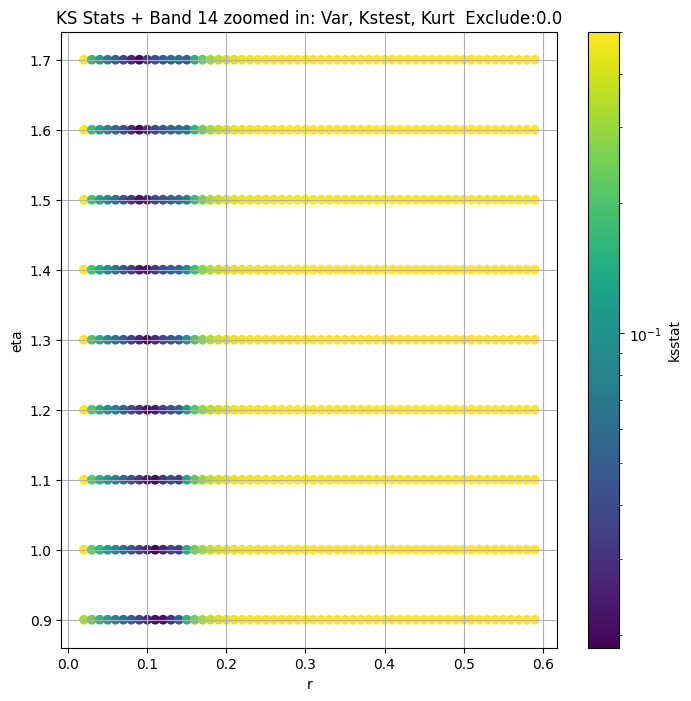

Band 17


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.0035824096663399294, var: 366125476700060.2


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.00337622245038105, var: 370004804874437.8


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.0028073232448452973, var: 374384071406958.7


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.0023341073306599874, var: 379641598277569.5


  0%|          | 0/289 [00:00<?, ?it/s]

Finding Minimum after computing 289 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.002003152511192069, var: 388122981379094.44
Number of samples: 100000, Without approximation : 100000.0


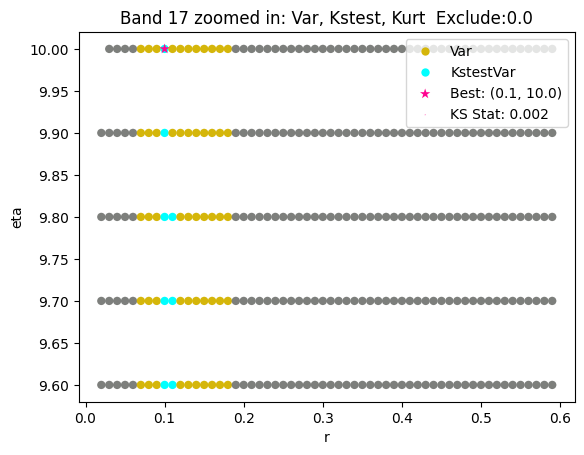

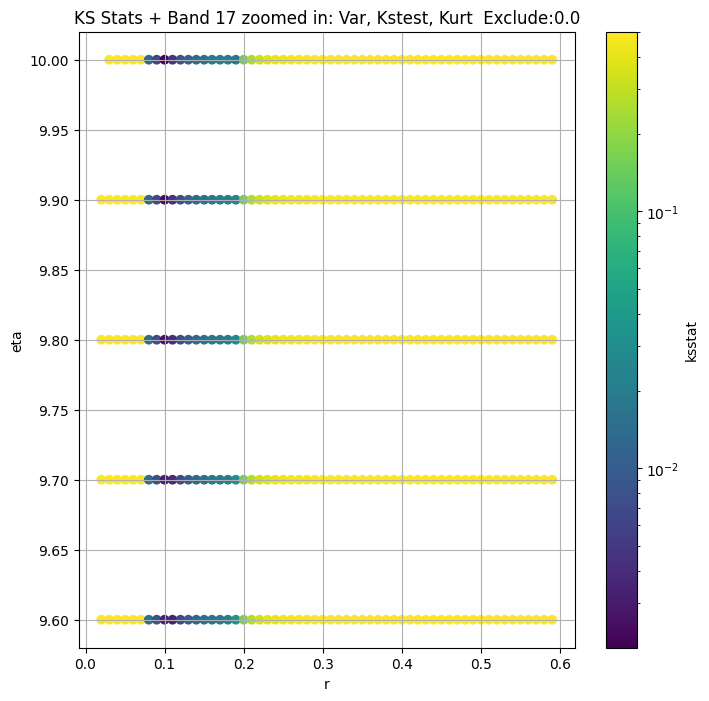

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 100 = 200, ksstat: 0.003724312949414787, var: 62454576015137.32


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 75 = 175, ksstat: 0.0033657428904910296, var: 63202954436453.05


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 50 = 150, ksstat: 0.002990719075188872, var: 64013779007361.49


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 25 = 125, ksstat: 0.002687044347416706, var: 64898270053047.17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + 0 = 100, ksstat: 0.0023226763344751065, var: 65872868398802.54


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -25 = 75, ksstat: 0.002656248849746634, var: 66976664808755.21


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -50 = 50, ksstat: 0.0032041526580108837, var: 68280300841399.86


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -75 = 25, ksstat: 0.003909511051296388, var: 69939558688939.84


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 100.0 + -100 = 0, ksstat: 0.005324975743962623, var: 73427182295489.95
Number of samples: 100000, Without approximation : 100000.0


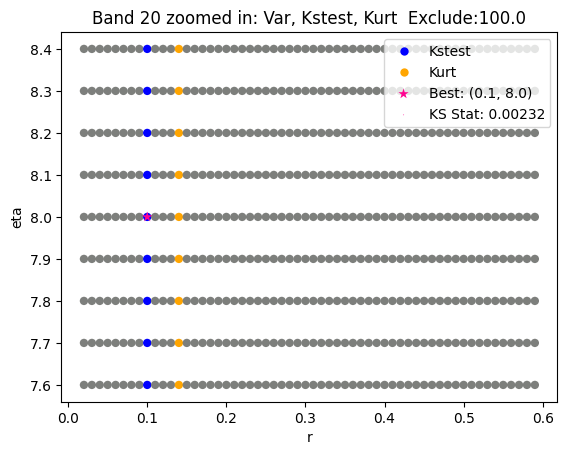

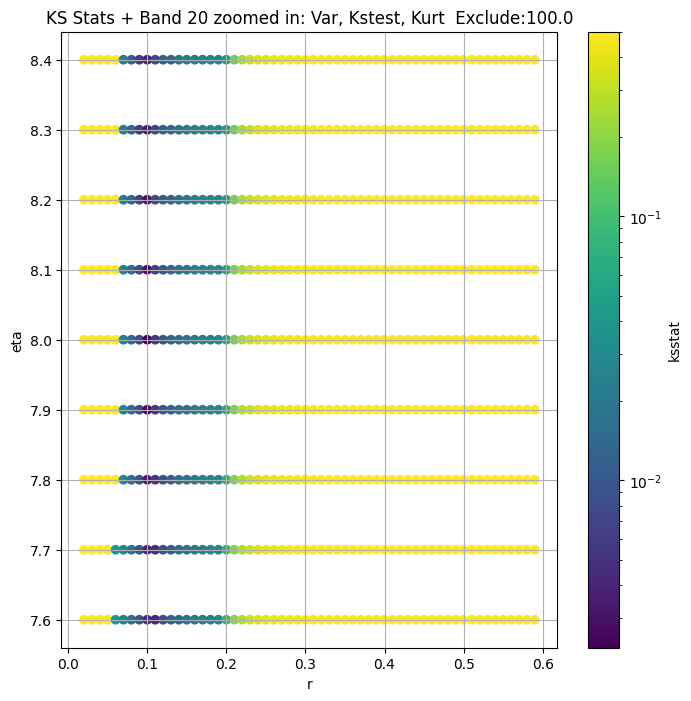

Band 23


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.0026085248415771978, var: 10293759990584.95


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0020950985949106035, var: 10401397065165.375


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.001624039238280004, var: 10520746265394.385


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.001985544625925817, var: 10656665189063.217


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0008036548109976449, var: 10822123149919.742


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0028498253195768375, var: 11116873638858.572
Number of samples: 100000, Without approximation : 100000.0


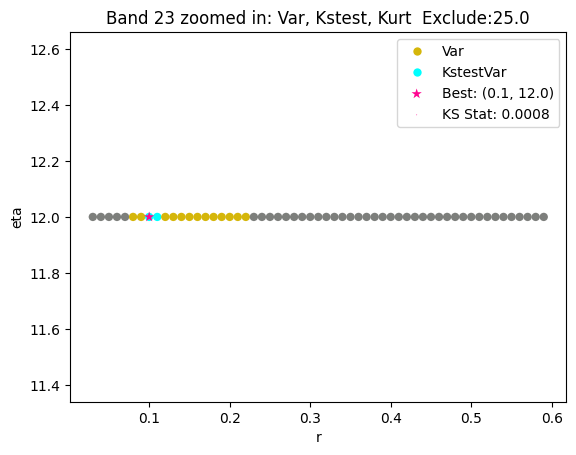

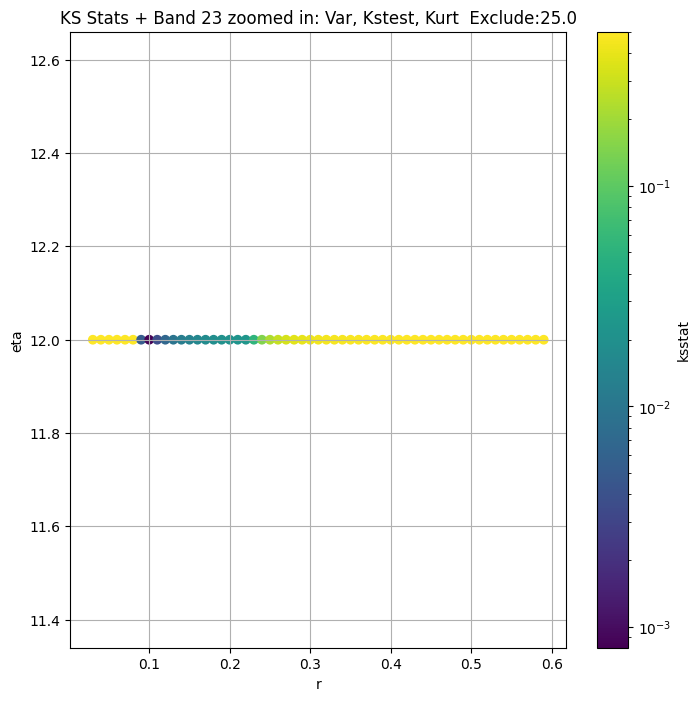

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.002858293147102252, var: 2853401147623.2056


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.0022272250478248753, var: 2895879483446.0874


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0016346423130262286, var: 2945051671852.624


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0008199773478311315, var: 3005852429549.024


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0006164542568853904, var: 3114393648514.945
Number of samples: 100000, Without approximation : 100000.0


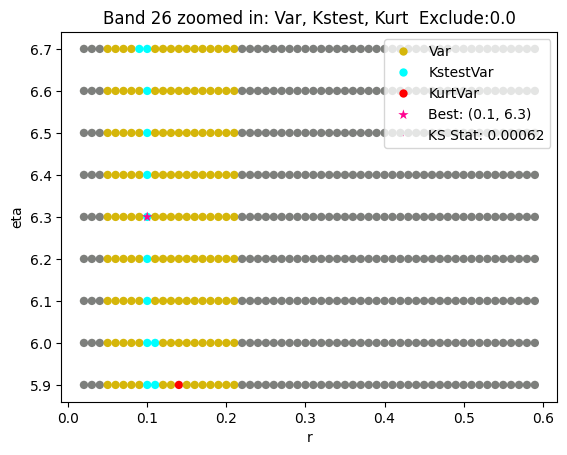

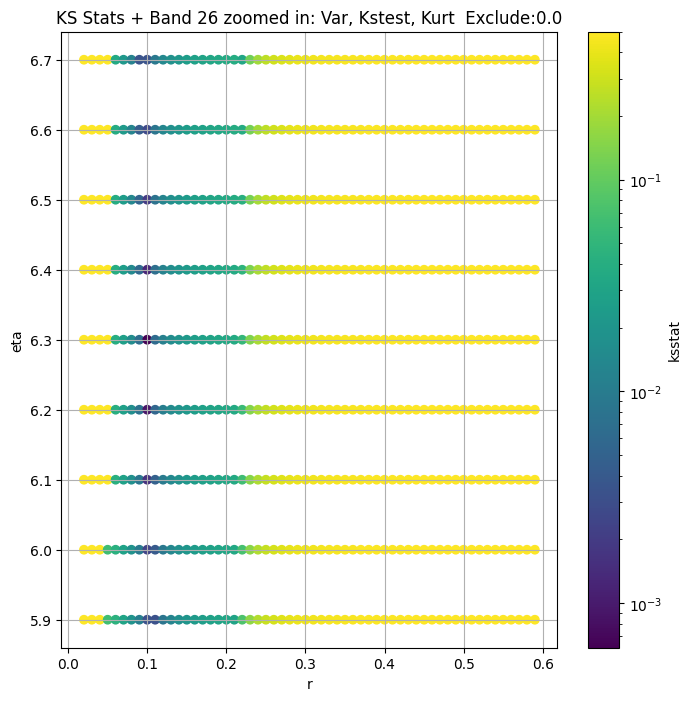

Band 29


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 100 = 100, ksstat: 0.004748678759322583, var: 60739585150.4249


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 75 = 75, ksstat: 0.004278389157658366, var: 61592223080.54566


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 50 = 50, ksstat: 0.003714708731552538, var: 62562204998.12691


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 25 = 25, ksstat: 0.0030160617287310204, var: 63729561196.566925


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 0 = 0, ksstat: 0.0021146689795213808, var: 65762145352.27044
Number of samples: 100000, Without approximation : 100000.0


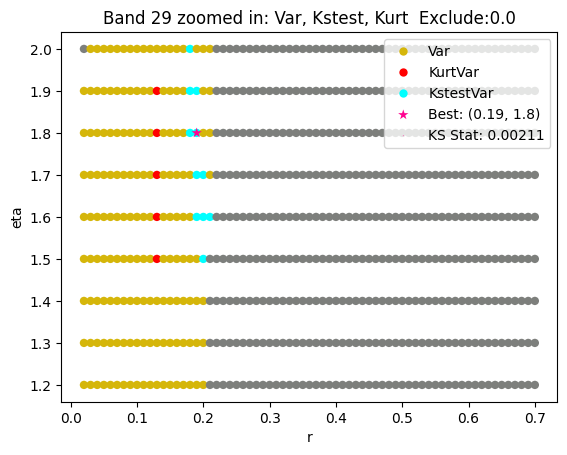

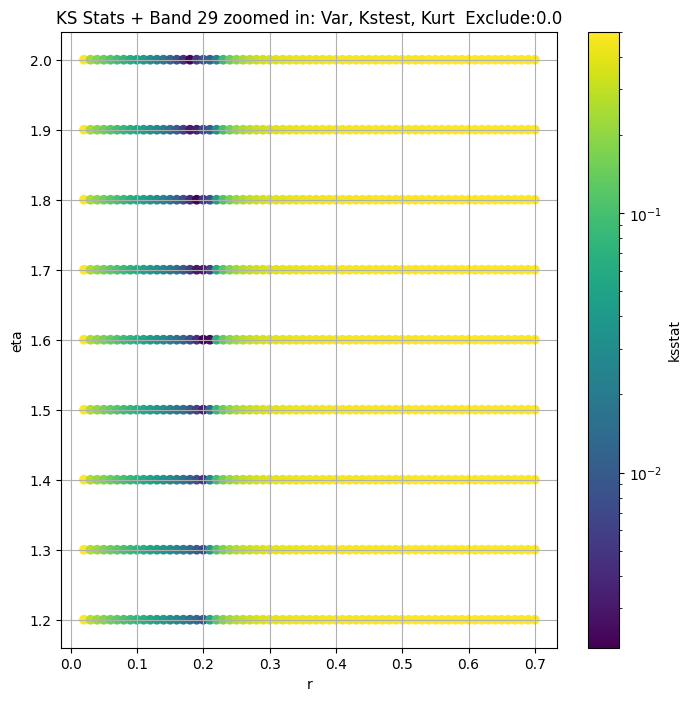

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     4.006317e+14  3.593028e+14  4.462146e+14    8.316574    5.757519   
5     9.461269e+14  8.322204e+14  1.067498e+15   21.399463   18.452861   
8     1.934537e+14  1.669650e+14  2.235244e+14   30.002404   21.744311   
11    1.438426e+13  1.162389e+13  1.914527e+13  100.202853   14.093921   
14    4.126319e+14  3.763275e+14  4.524124e+14   10.744119    7.456208   
17    3.881230e+14  3.657422e+14  4.122021e+14    3.374916    2.279853   
20    7.342718e+13  6.716078e+13  8.168062e+13   11.901693    5.121552   
23    1.111687e+13  1.043827e+13  1.190148e+13    4.427513    2.454238   
26    3.114394e+12  2.886462e+12  3.378224e+12    7.238748    4.201065   
29    6.576215e+10  6.101267e+10  7.119539e+10    6.770875    4.171933   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      10.650913         2880.0             0.006904        0.1         14.0   
5      24.572022         8640.0             0.014009        0.1          3.3   
8      39.769151        24480.0             0.010485        0.1          5.0   
11    274.104715        67680.0             0.003880        0.2          8.5   
14     16.715038       100000.0             0.018681        0.1          1.3   
17      6.281314       100000.0             0.002003        0.1         10.0   
20     40.059997       100000.0             0.002323        0.1          8.0   
23     12.285351       100000.0             0.000804        0.1         12.0   
26     17.518762       100000.0             0.000616        0.1          6.3   
29     17.270431       100000.0             0.002186        0.2          1.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.872353e-08                    25.0        3.055908e+14   
5      2.802386e-03                   150.0        4.391410e+14   
8      3.577609e-05                   350.0        9.326665e+13   
11     2.538496e+04                   250.0        9.747499e+12   
14     3.264440e-01                     0.0        4.126319e+14   
17     6.554589e-07                     0.0        3.881230e+14   
20     6.954832e-07                   100.0        6.587287e+13   
23     3.885897e-09                    25.0        1.082212e+13   
26     2.145206e-07                     0.0        3.114394e+12   
29     4.073014e+04                     0.0        6.576215e+10   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.025248          0.006641    0.11      14.0   
5                    0.014591          0.014009    0.10       3.3   
8                    0.008673          0.010485    0.10       5.0   
11                   0.005218          0.003709    0.19       8.7   
14                   0.004293          0.018681    0.10       1.3   
17                   0.004293          0.002003    0.10      10.0   
20                   0.004293          0.002323    0.10       8.0   
23                   0.004293          0.000804    0.10      12.0   
26                   0.004293          0.000616    0.10       6.3   
29                   0.004293          0.002115    0.19       1.8   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     6.889972e-06                 25.0        41517  
5     2.802386e-03                150.0         9720  
8     3.577609e-05                350.0        17425  
11    6.255351e+03                225.0       128485  
14    3.264440e-01                  0.0         5272  
17    6.554589e-07                  0.0       480540  
20    6.954832e-07                100.0       337500  
23    3.885897e-09              

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

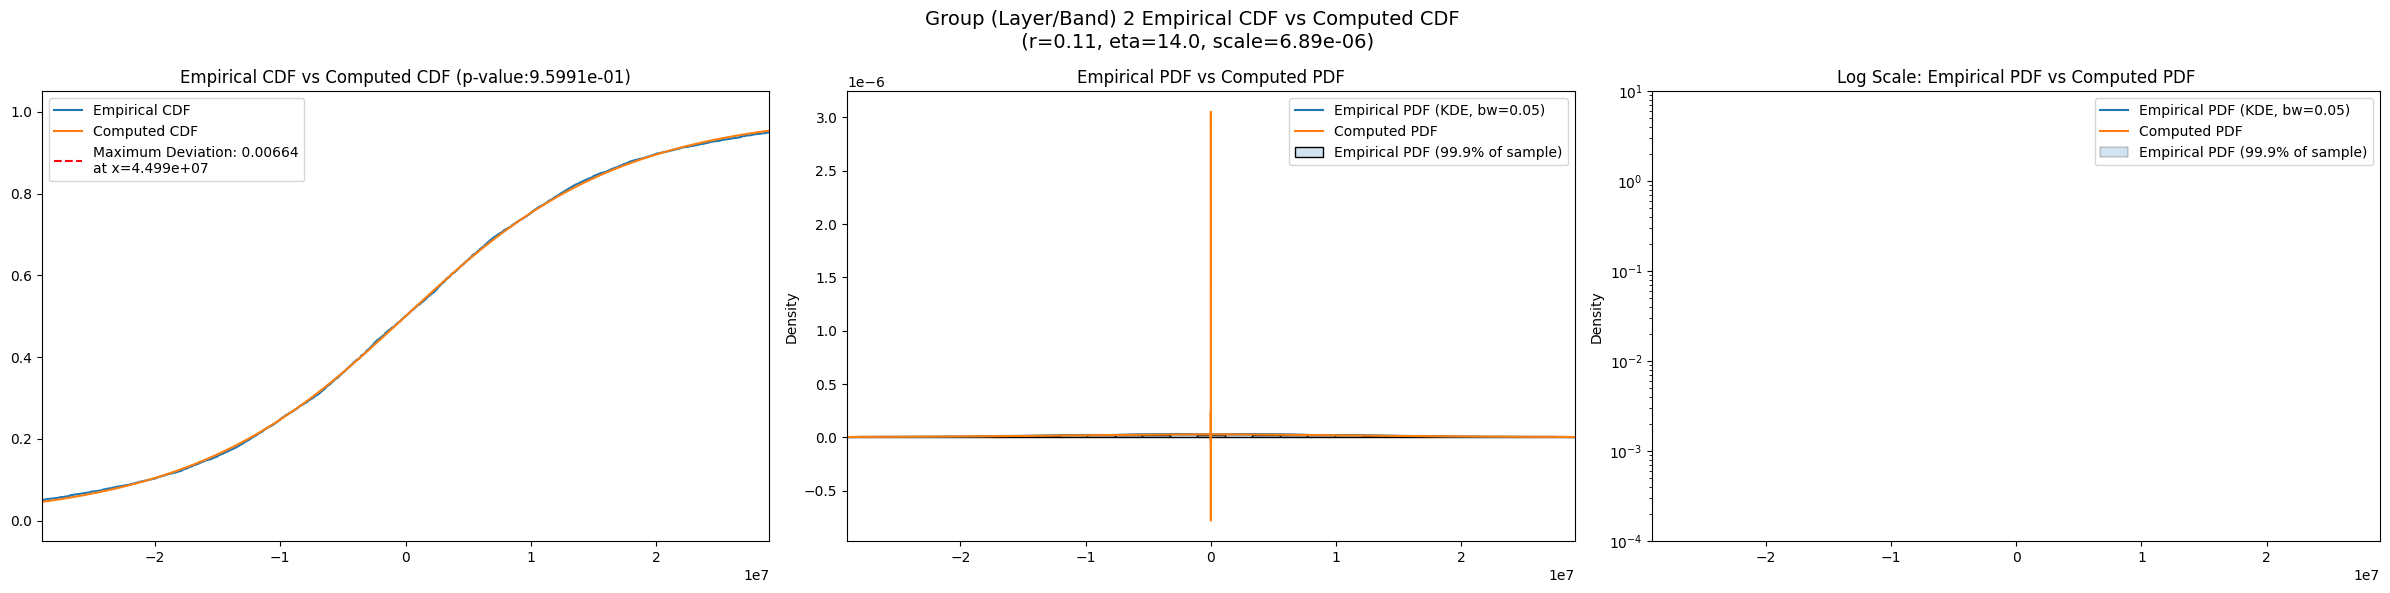

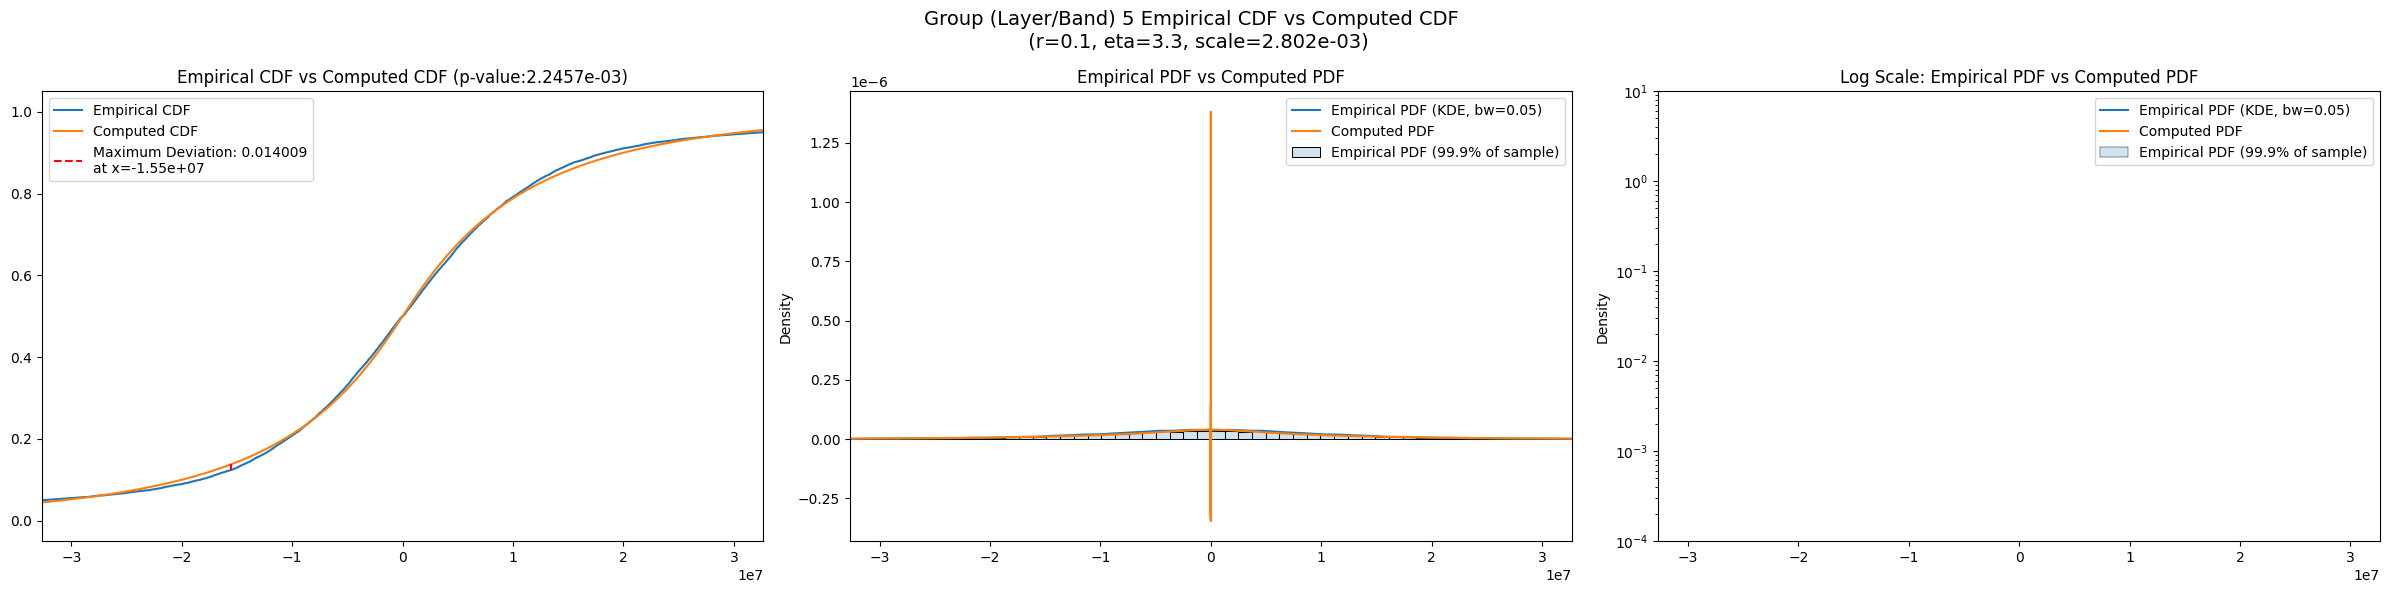

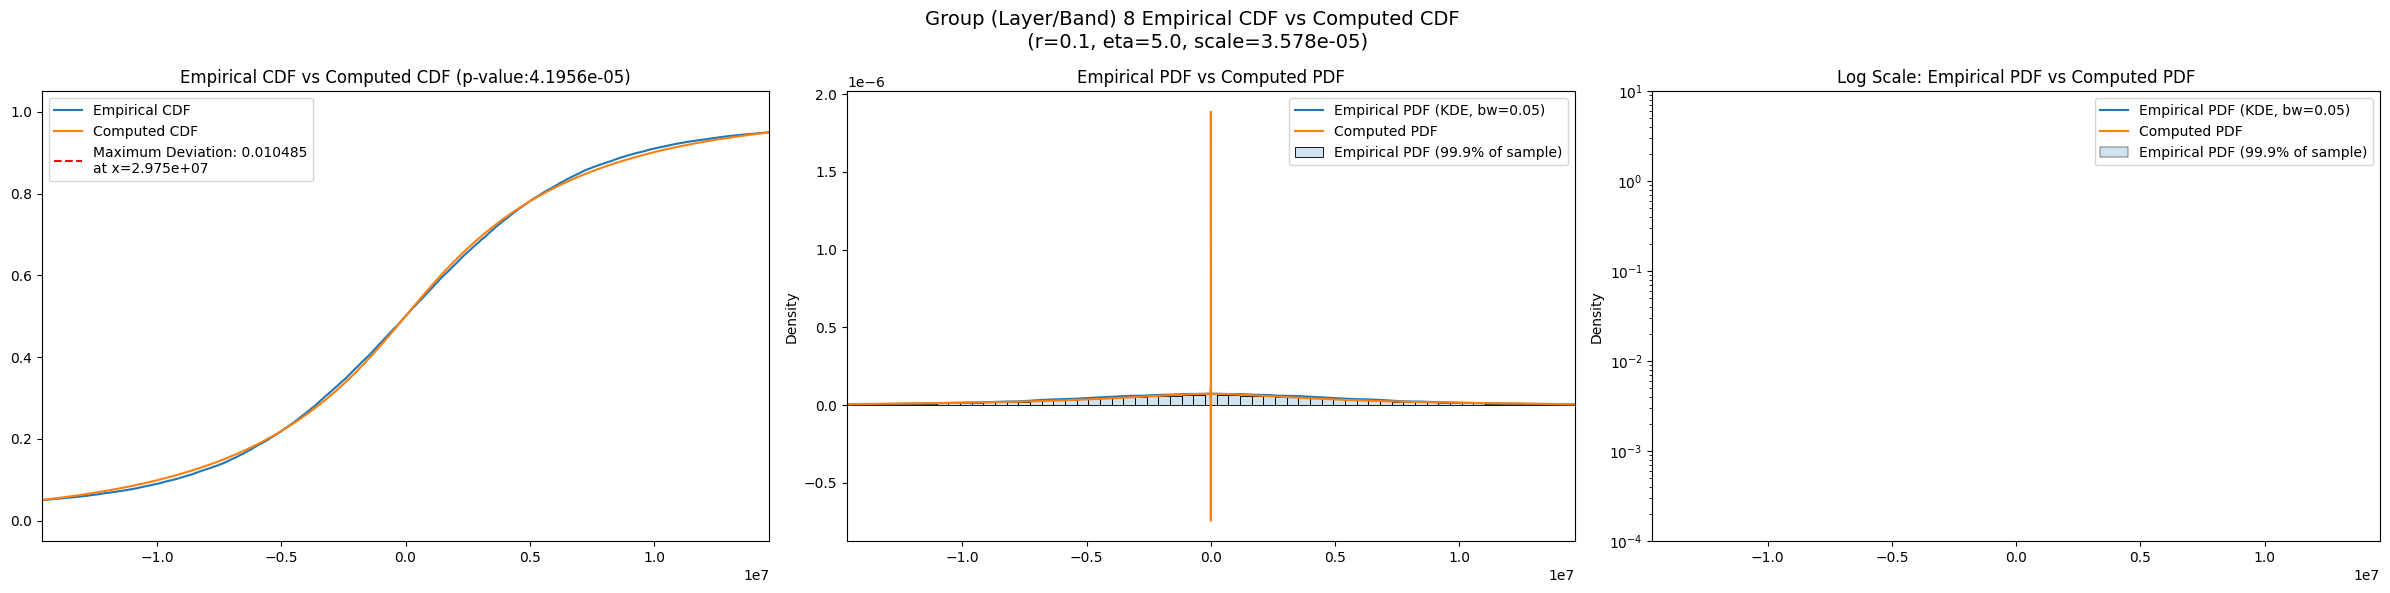

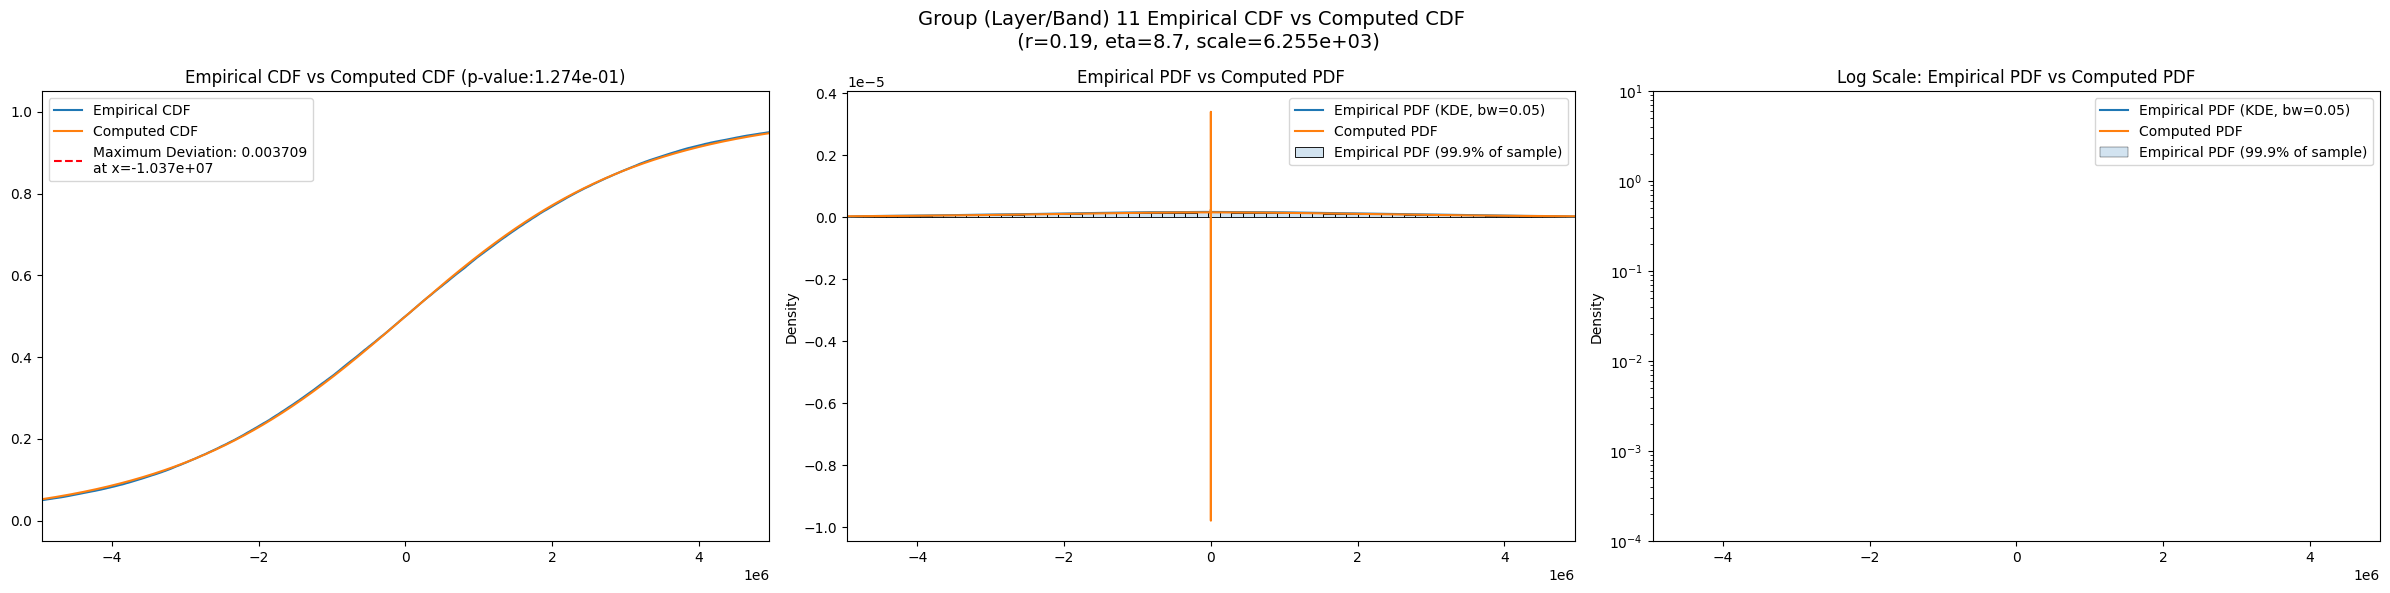

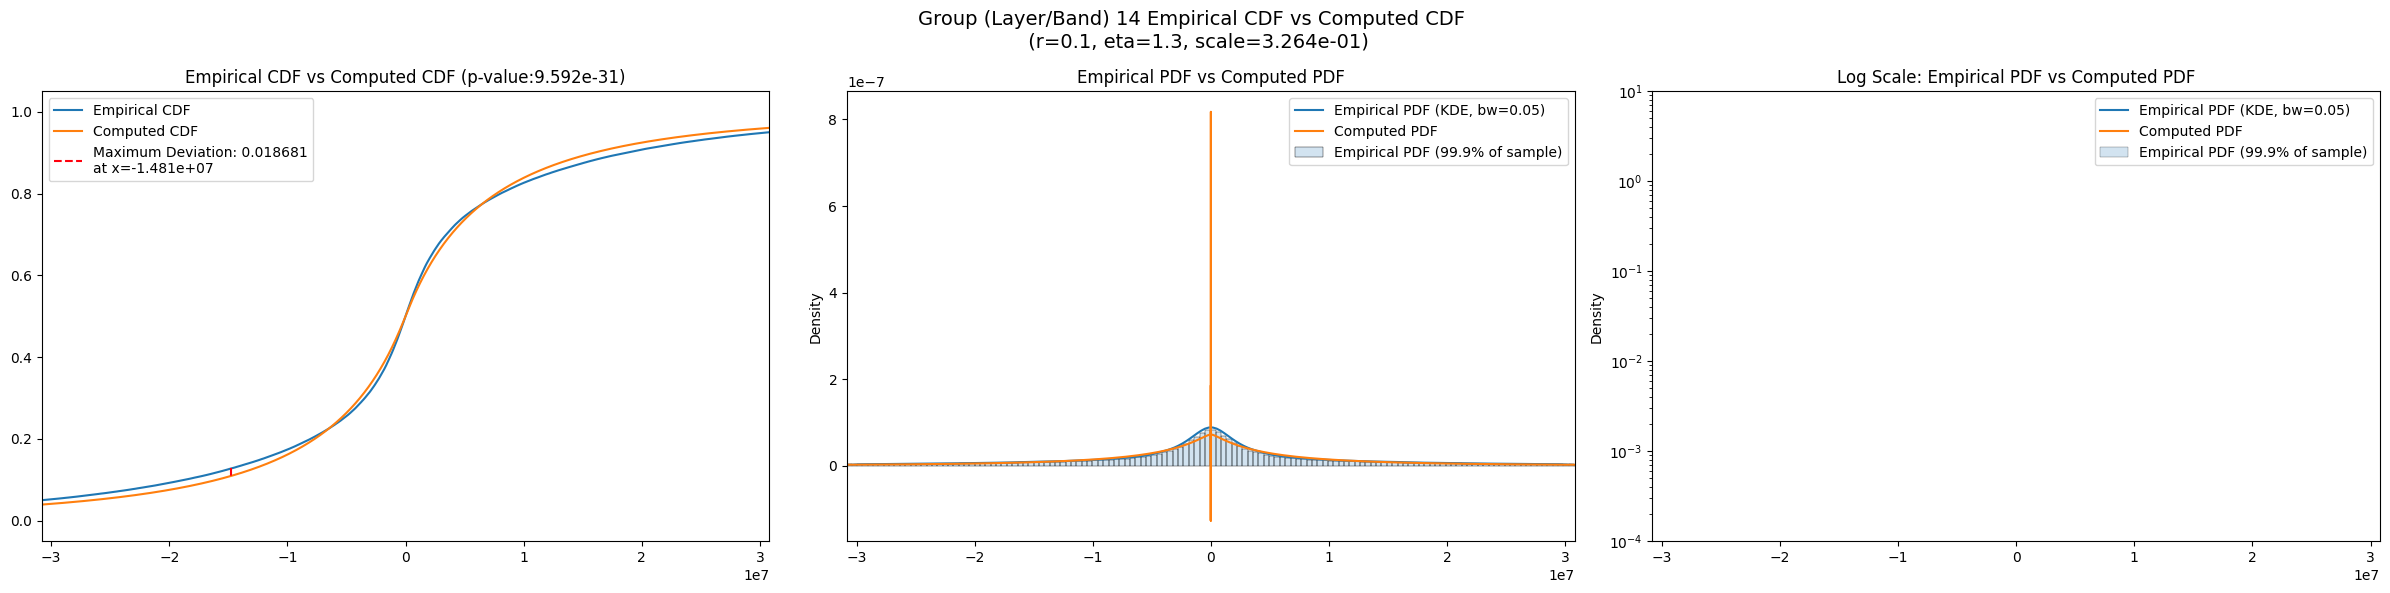

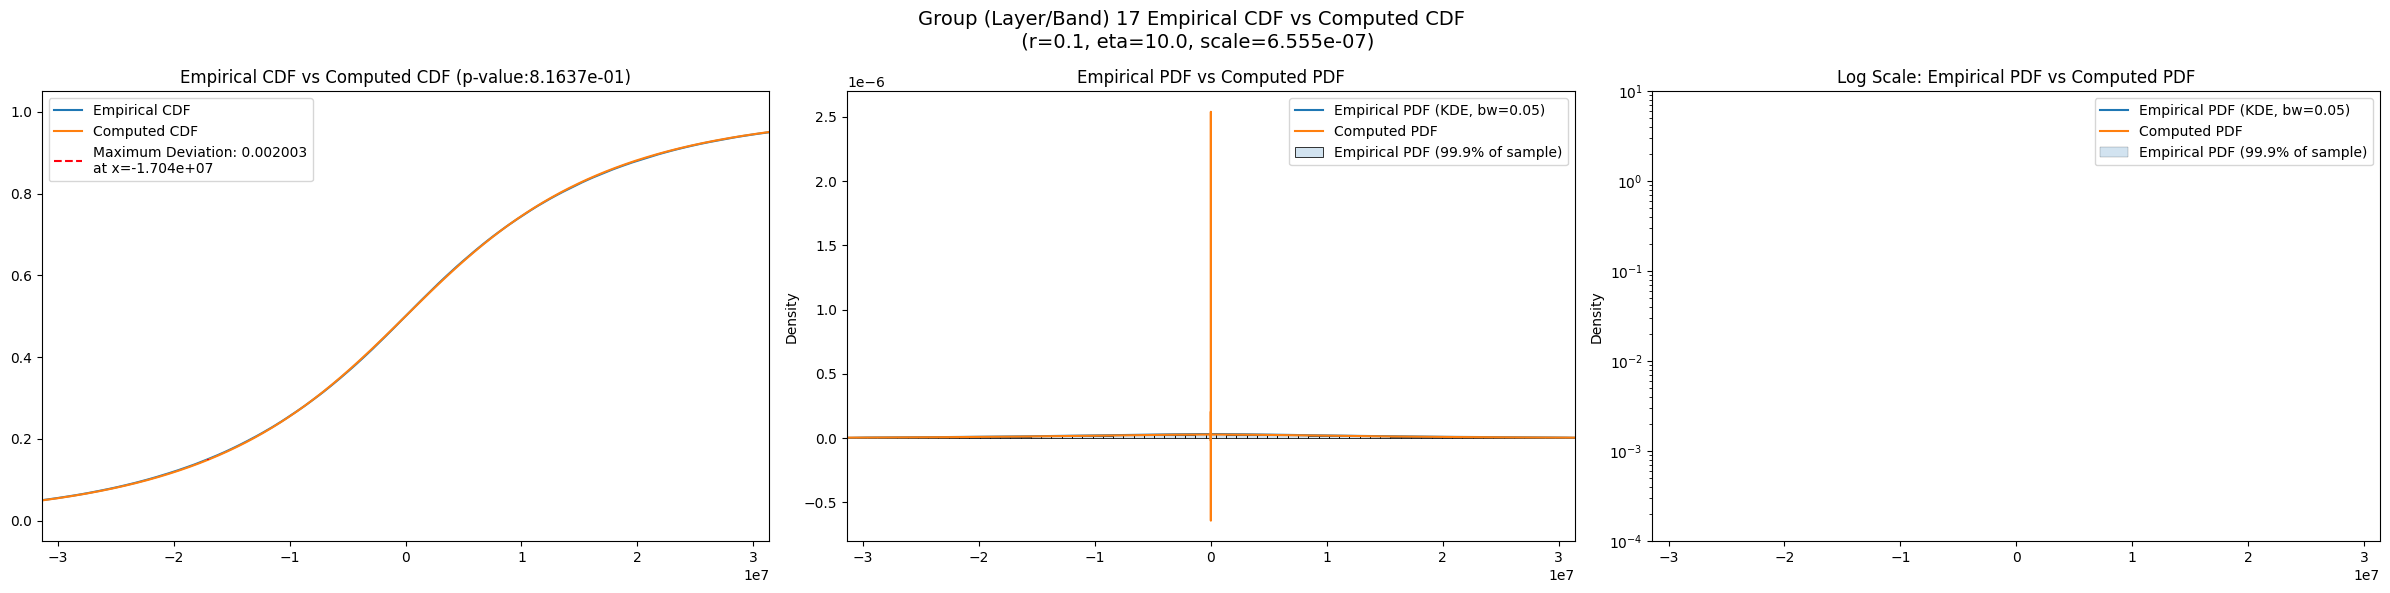

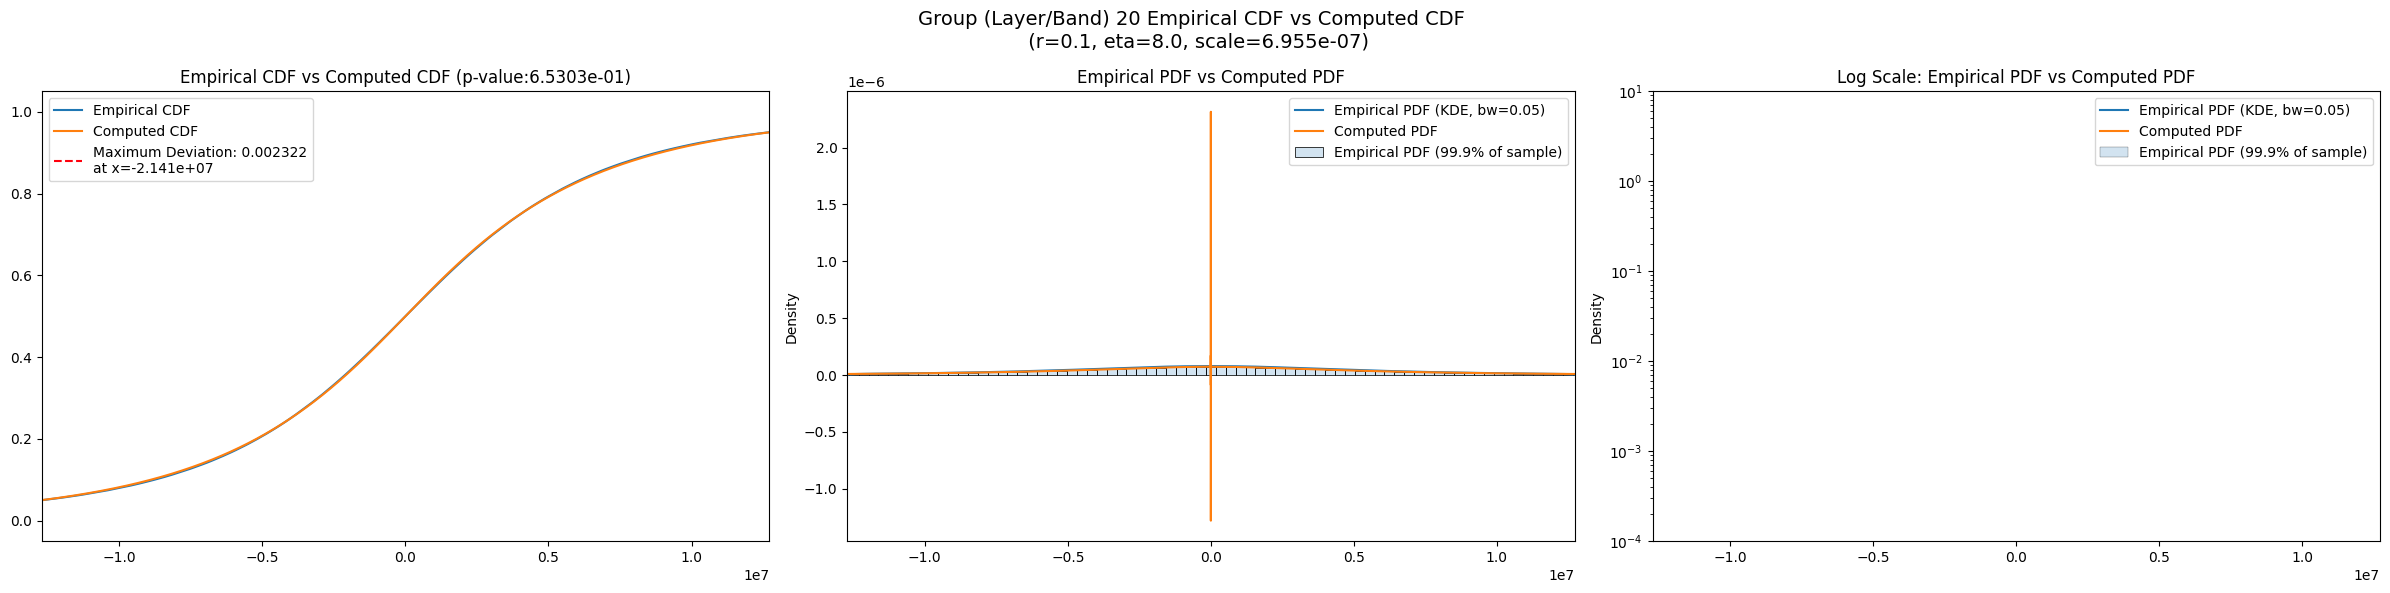

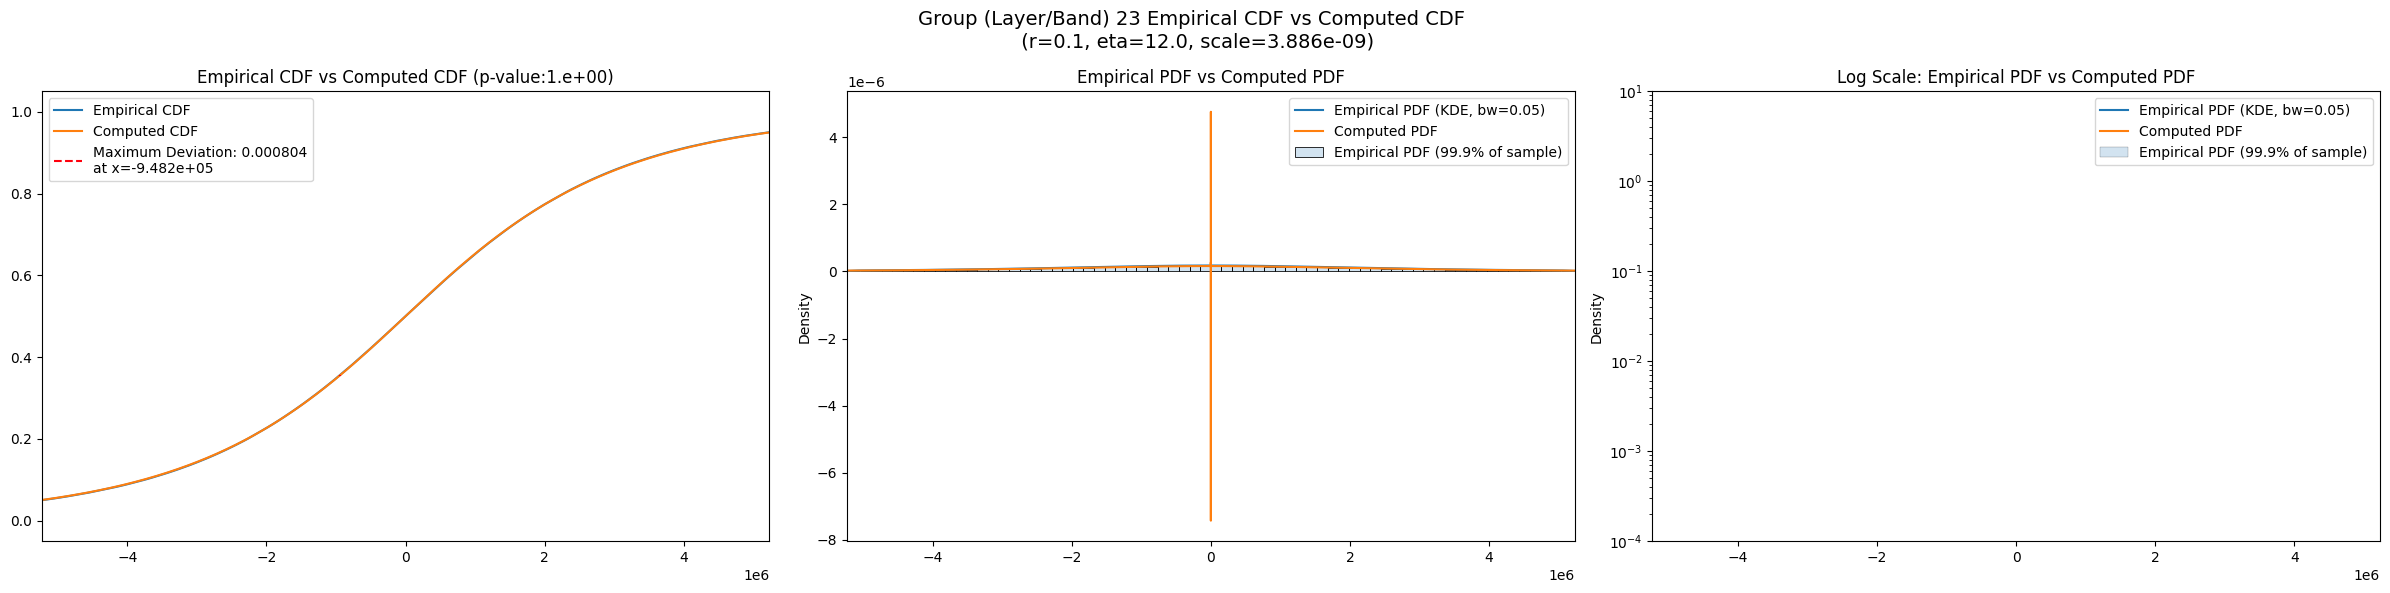

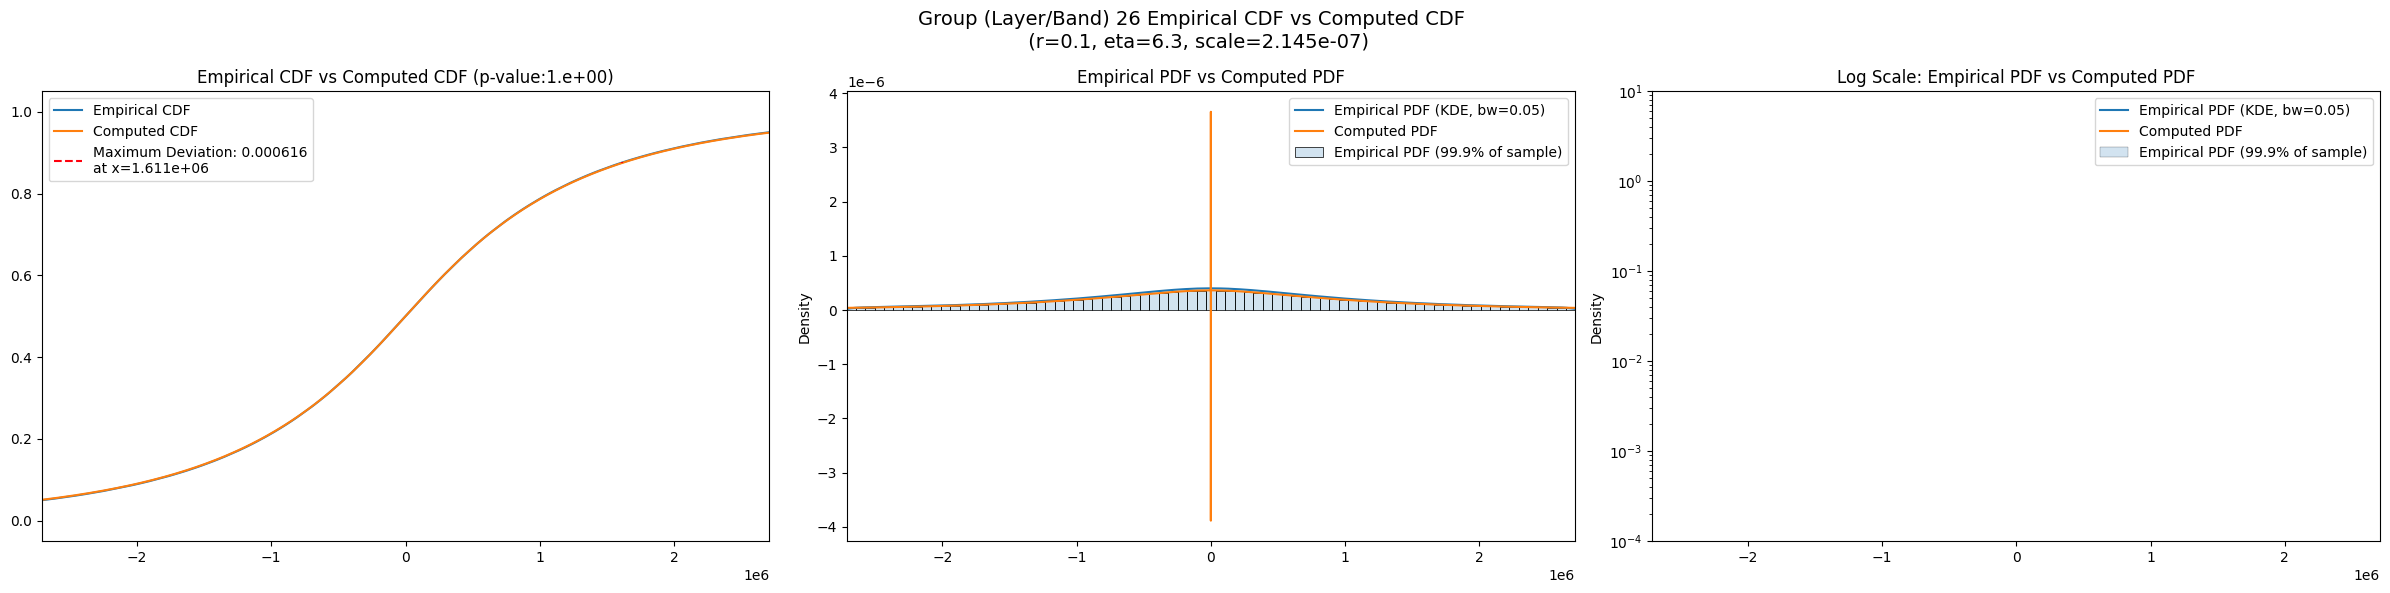

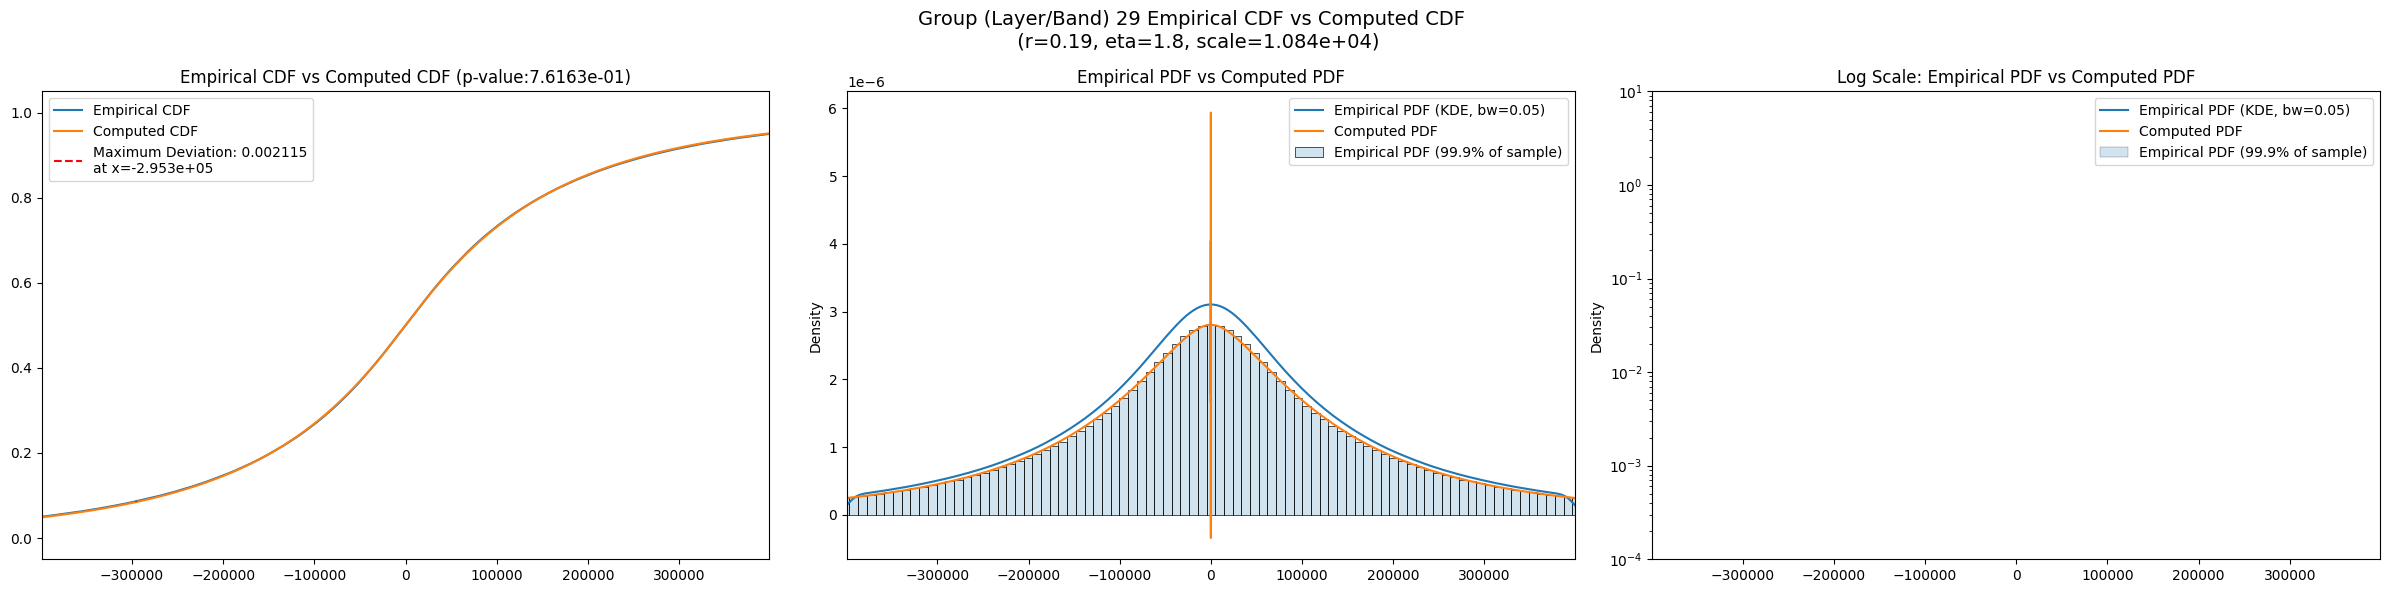

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     4.006317e+14  3.593028e+14  4.462146e+14    8.316574    5.757519   
5     9.461269e+14  8.322204e+14  1.067498e+15   21.399463   18.452861   
8     1.934537e+14  1.669650e+14  2.235244e+14   30.002404   21.744311   
11    1.438426e+13  1.162389e+13  1.914527e+13  100.202853   14.093921   
14    4.126319e+14  3.763275e+14  4.524124e+14   10.744119    7.456208   
17    3.881230e+14  3.657422e+14  4.122021e+14    3.374916    2.279853   
20    7.342718e+13  6.716078e+13  8.168062e+13   11.901693    5.121552   
23    1.111687e+13  1.043827e+13  1.190148e+13    4.427513    2.454238   
26    3.114394e+12  2.886462e+12  3.378224e+12    7.238748    4.201065   
29    6.576215e+10  6.101267e+10  7.119539e+10    6.770875    4.171933   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      10.650913         2880.0             0.006904        0.1         14.0   
5      24.572022         8640.0             0.014009        0.1          3.3   
8      39.769151        24480.0             0.010485        0.1          5.0   
11    274.104715        67680.0             0.003880        0.2          8.5   
14     16.715038       100000.0             0.018681        0.1          1.3   
17      6.281314       100000.0             0.002003        0.1         10.0   
20     40.059997       100000.0             0.002323        0.1          8.0   
23     12.285351       100000.0             0.000804        0.1         12.0   
26     17.518762       100000.0             0.000616        0.1          6.3   
29     17.270431       100000.0             0.002186        0.2          1.6   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       1000000.0              0.429840          0.000000e+00   
5     ...       1000000.0              0.409689          0.000000e+00   
8     ...       1000000.0              0.350693          0.000000e+00   
11    ...       1000000.0              0.221922          0.000000e+00   
14    ...       1000000.0              0.337804          0.000000e+00   
17    ...       1000000.0              0.424483          0.000000e+00   
20    ...       1000000.0              0.341218          0.000000e+00   
23    ...       1000000.0              0.215988          0.000000e+00   
26    ...       1000000.0              0.071171          0.000000e+00   
29    ...        189781.0              0.032972          6.881460e-95   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         1000000.0             0.393690         0.000000e+00  1000000.0   
5         1000000.0             0.372671         0.000000e+00  1000000.0   
8         1000000.0             0.306198         0.000000e+00  1000000.0   
11        1000000.0             0.177872         0.000000e+00  1000000.0   
14        1000000.0             0.295791         0.000000e+00  1000000.0   
17        1000000.0             0.391073         0.000000e+00  1000000.0   
20        1000000.0             0.296043         0.000000e+00  1000000.0   
23        1000000.0             0.171656         0.000000e+00  1000000.0   
26        1000000.0             0.030243         6.821130e-80   968913.0   
29         165944.0             0.006086         1.206710e-03   136741.0   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.370980       0.000000          9.995033e-01  
5          0.349222       0.000000          6.671100e-02  
8          0.282142       0.000000          9.124722e-03  
11         0.152816       0.000000          3.089030e-01  
14         0.2719

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006904                 0.025248          0.006641   
5                0.014009                 0.014591          0.014009   
8                0.010485                 0.008673          0.010485   
11               0.003880                 0.005218          0.003709   
14               0.018681                 0.004293          0.018681   
17               0.002003                 0.004293          0.002003   
20               0.002323                 0.004293          0.002323   
23               0.000804                 0.004293          0.000804   
26               0.000616                 0.004293          0.000616   
29               0.002186                 0.004293          0.002115   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.429840             0.393690       0.370980  
5                 0.409689             0.372671       0.349222  
8                 0.350693             0.306198       0.282142  
11                0.221922             0.177872       0.152816  
14                0.337804             0.295791       0.271928  
17                0.424483             0.391073       0.368204  
20                0.341218             0.296043       0.271990  
23                0.215988             0.171656       0.146689  
26                0.071171             0.030243       0.008029  
29                0.032972             0.006086       0.006929

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           3.055908e+14          0.006641    0.11      14.0  6.889972e-06   
5           4.391410e+14          0.014009    0.10       3.3  2.802386e-03   
8           9.326665e+13          0.010485    0.10       5.0  3.577609e-05   
11          9.747499e+12          0.003709    0.19       8.7  6.255351e+03   
14          4.126319e+14          0.018681    0.10       1.3  3.264440e-01   
17          3.881230e+14          0.002003    0.10      10.0  6.554589e-07   
20          6.587287e+13          0.002323    0.10       8.0  6.954832e-07   
23          1.082212e+13          0.000804    0.10      12.0  3.885897e-09   
26          3.114394e+12          0.000616    0.10       6.3  2.145206e-07   
29          6.576215e+10          0.002115    0.19       1.8  1.084031e+04   

      best_exclude_cutoff  
band                       
2                    25.0  
5                   150.0  
8                   350.0  
11                  225.0  
14                    0.0  
17                    0.0  
20                  100.0  
23                   25.0  
26                    0.0  
29                    0.0